# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [3]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [4]:
scores = net.loss(X)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# The difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-2.53776973  1.3061796  -4.73592451]
 [-2.09059267  1.2665469  -7.0689651 ]
 [-3.45969168  3.47552256 -6.59768448]
 [-2.10879219  1.45425391 -3.33920145]
 [-0.24213407 -0.80834314 -0.7663275 ]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
40.72990168


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [5]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Difference between your loss and correct loss:
2.89616702696


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [6]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
  print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

b2 max relative error: 9.207201e-11
b1 max relative error: 3.162477e-09
W1 max relative error: 7.140046e-10
W2 max relative error: 2.741818e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.000705618514897


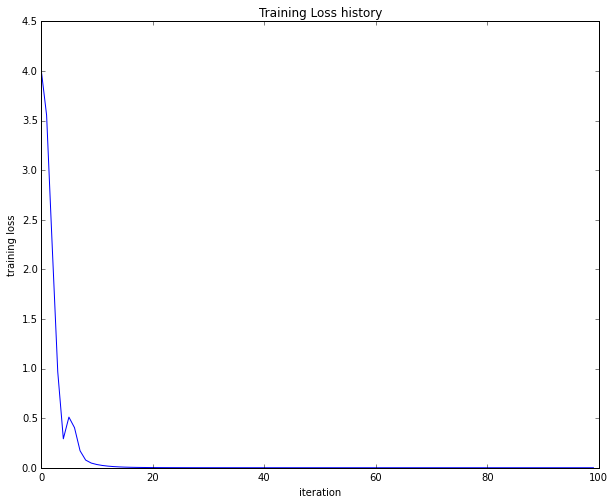

In [7]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=100, verbose=False)

print 'Final training loss: ', stats['loss_history'][-1]

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [4]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

In [ ]:
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

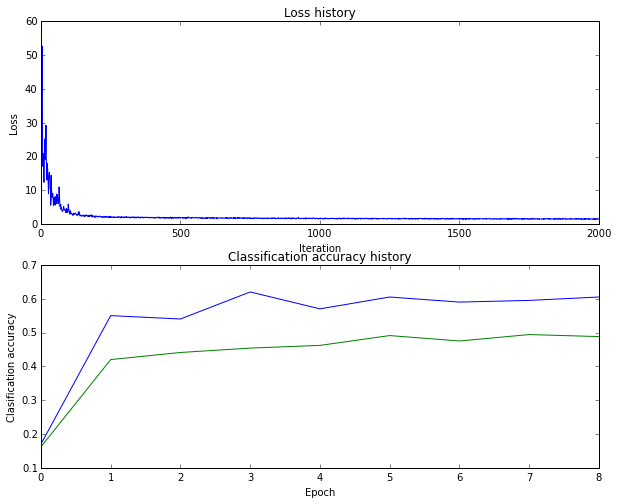

In [10]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [ ]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

##==================AccuracyImprovement===========================

# Learning rate effect:

From the above we can observe that the learning rate increases and gives a good value at 1e-3 to a level of about 
0.2 more than at 1e-4, so we change the parameter learning rate from 1e-4 to 1e-3 to get a better accuracy.

Also observe that when the learning rate is changed from 1e-4 to 1e-3 the loss function also started decreasing 
from linear to polynomial

Best net parameters : 
    
    learning_rate = 1e-3
    learning rate decay = 0.95
    batch_size = 200
    num_iters = 2000 (not sure but better that 1000!)
    hidden neurons = 150 (not sure)
    reg strength = 0.5
    no. of epochs = ?
    any use of PCA ?
    any use of dropout ?
    

Learning rate:  1e-05
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.260459
iteration 200 / 1000: loss 3.021276
iteration 300 / 1000: loss 2.926908
iteration 400 / 1000: loss 2.457121
iteration 500 / 1000: loss 2.630357
iteration 600 / 1000: loss 2.666278
iteration 700 / 1000: loss 2.073913
iteration 800 / 1000: loss 2.263435
iteration 900 / 1000: loss 2.314455
Validation accuracy:  0.318


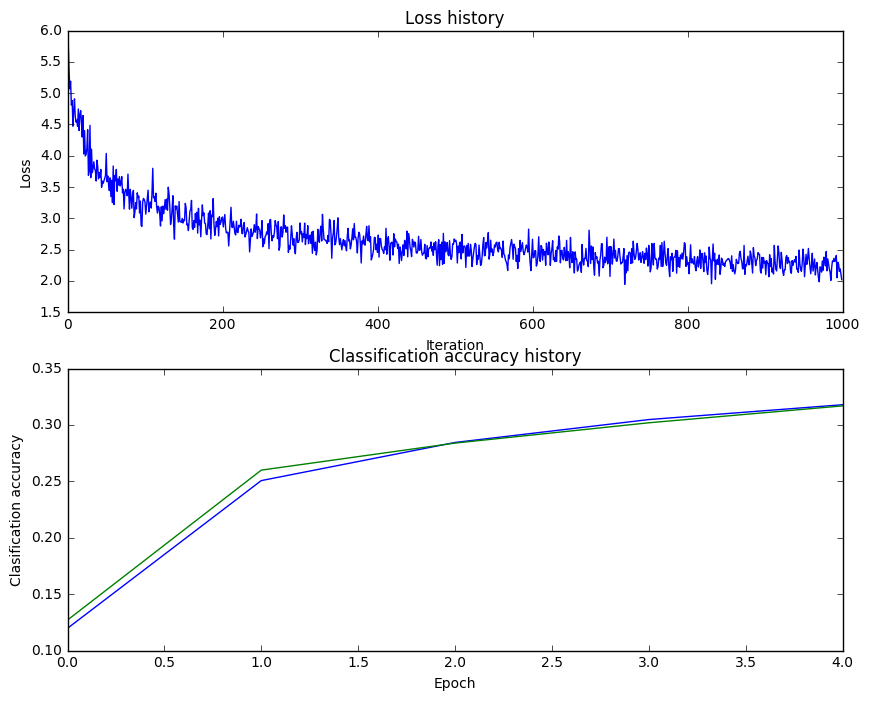

Learning rate:  0.0001
iteration 0 / 1000: loss 2.381379
iteration 100 / 1000: loss 2.009640
iteration 200 / 1000: loss 1.826203
iteration 300 / 1000: loss 1.963194
iteration 400 / 1000: loss 1.989156
iteration 500 / 1000: loss 1.909592
iteration 600 / 1000: loss 1.631801
iteration 700 / 1000: loss 1.732589
iteration 800 / 1000: loss 1.733986
iteration 900 / 1000: loss 1.435335
Validation accuracy:  0.393


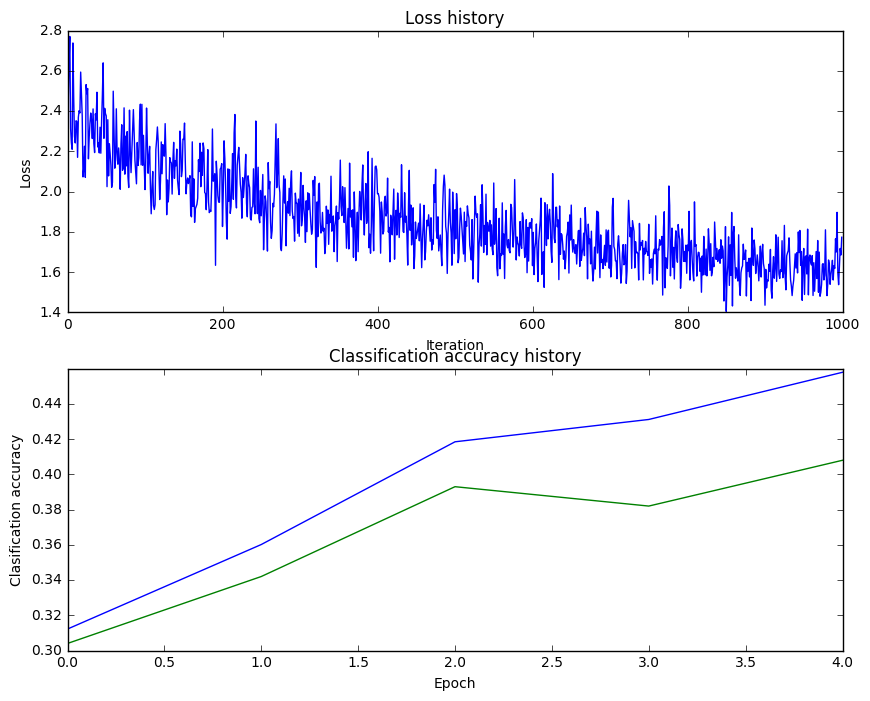

Learning rate:  0.001
iteration 0 / 1000: loss 1.657592
iteration 100 / 1000: loss 3.769286
iteration 200 / 1000: loss 1.491025
iteration 300 / 1000: loss 1.738910
iteration 400 / 1000: loss 1.494201
iteration 500 / 1000: loss 1.321767
iteration 600 / 1000: loss 1.370810
iteration 700 / 1000: loss 1.424675
iteration 800 / 1000: loss 1.242373
iteration 900 / 1000: loss 1.394728
Validation accuracy:  0.483


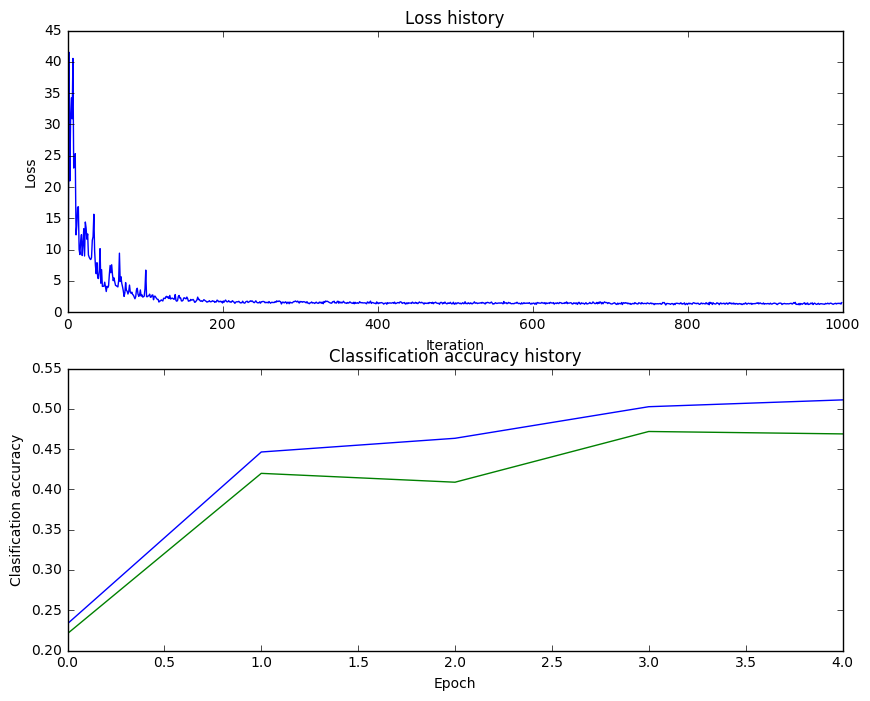

Learning rate:  0.01
iteration 0 / 1000: loss 1.312786


cs231n/classifiers/neural_net.py:112: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(correct_probs)) / X.shape[0]


iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf


cs231n/classifiers/neural_net.py:107: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores,axis=1,keepdims=True)
cs231n/classifiers/neural_net.py:107: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores,axis=1,keepdims=True)
cs231n/classifiers/neural_net.py:134: RuntimeWarning: invalid value encountered in less_equal
  da1[a1 <= 0] = 0


iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
Validation accuracy:  0.087


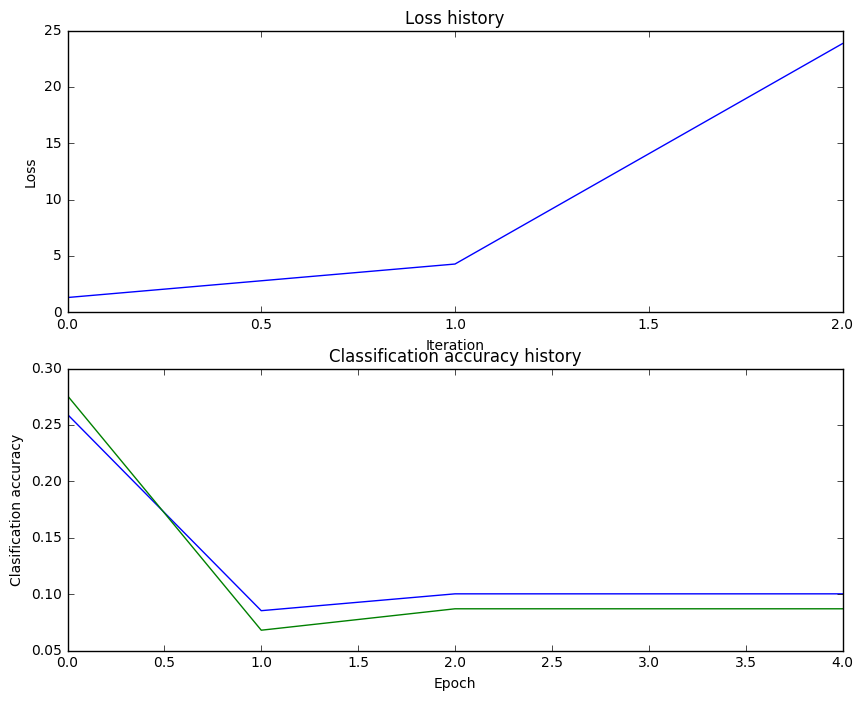

In [5]:
lr = range(-5,-1)
for i in lr:
    print "Learning rate: ", 10**i
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=10**i, learning_rate_decay=0.95,
            reg=0, verbose=True)

    # Predict on the validation set
    val_acc = (net.predict(X_val) == y_val).mean()
    print 'Validation accuracy: ', val_acc
    
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()


[ 0.0005  0.001   0.0015  0.002   0.0025  0.003   0.0035  0.004   0.0045
  0.005 ]
Learning rate:  0.0005
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.084540
iteration 200 / 1000: loss 2.925401
iteration 300 / 1000: loss 2.020012
iteration 400 / 1000: loss 1.792647
iteration 500 / 1000: loss 1.710706
iteration 600 / 1000: loss 1.788409
iteration 700 / 1000: loss 1.553508
iteration 800 / 1000: loss 1.609331
iteration 900 / 1000: loss 1.644252
Validation accuracy:  0.446


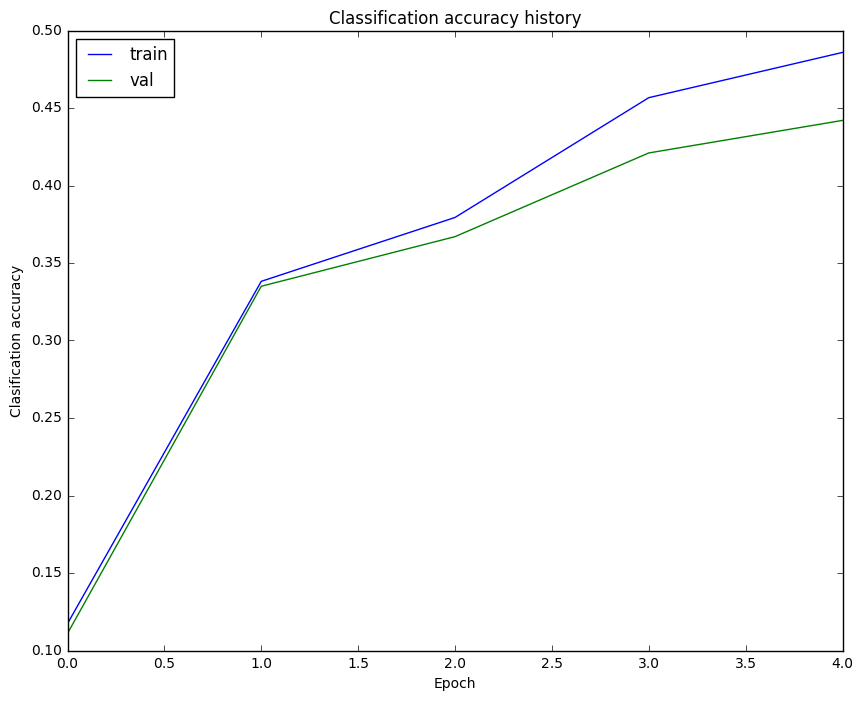

Learning rate:  0.0005
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.447245
iteration 200 / 1000: loss 2.647006
iteration 300 / 1000: loss 2.218066
iteration 400 / 1000: loss 1.704042
iteration 500 / 1000: loss 1.731282
iteration 600 / 1000: loss 1.773700
iteration 700 / 1000: loss 1.595138
iteration 800 / 1000: loss 1.570048
iteration 900 / 1000: loss 1.586842
Validation accuracy:  0.428


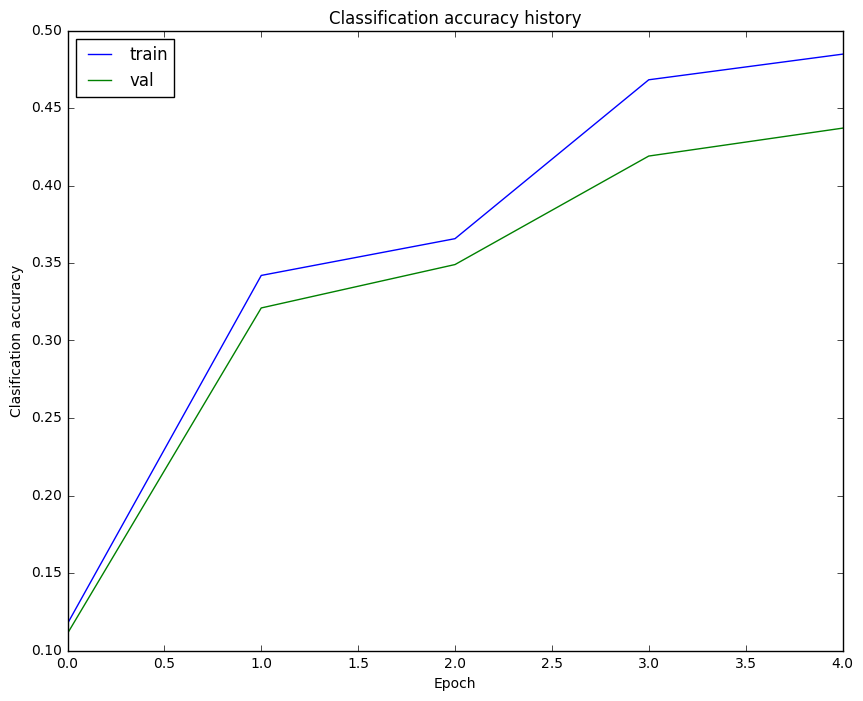

Learning rate:  0.0005
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.840206
iteration 200 / 1000: loss 2.769175
iteration 300 / 1000: loss 1.978706
iteration 400 / 1000: loss 1.837616
iteration 500 / 1000: loss 1.788032
iteration 600 / 1000: loss 1.687482
iteration 700 / 1000: loss 1.587012
iteration 800 / 1000: loss 1.624425
iteration 900 / 1000: loss 1.472372
Validation accuracy:  0.462


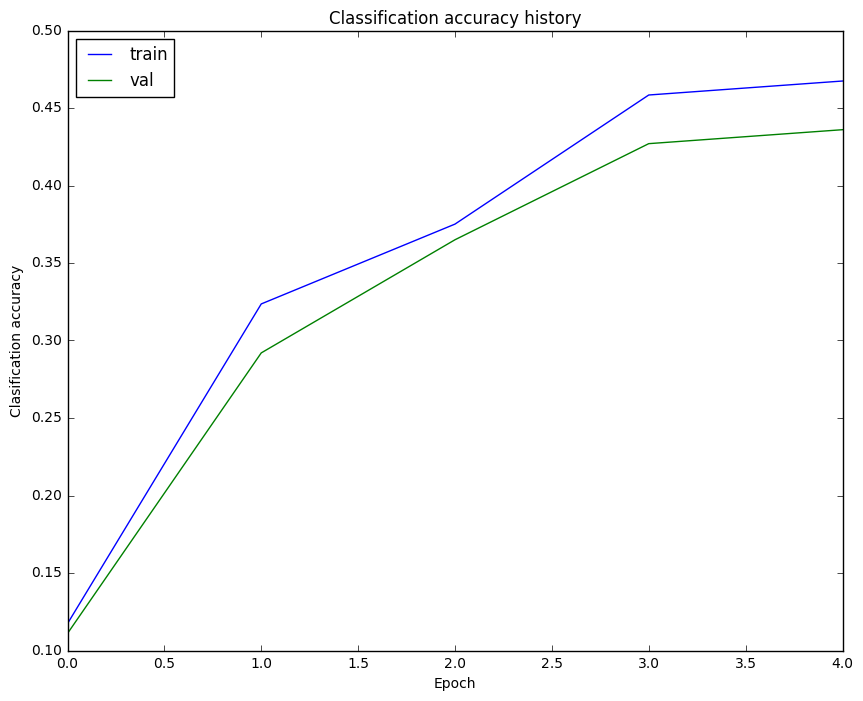

Learning rate:  0.001
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.416180
iteration 200 / 1000: loss 2.088266
iteration 300 / 1000: loss 1.705461
iteration 400 / 1000: loss 1.514677
iteration 500 / 1000: loss 1.496244
iteration 600 / 1000: loss 1.617070
iteration 700 / 1000: loss 1.441599
iteration 800 / 1000: loss 1.404450
iteration 900 / 1000: loss 1.359683
Validation accuracy:  0.451


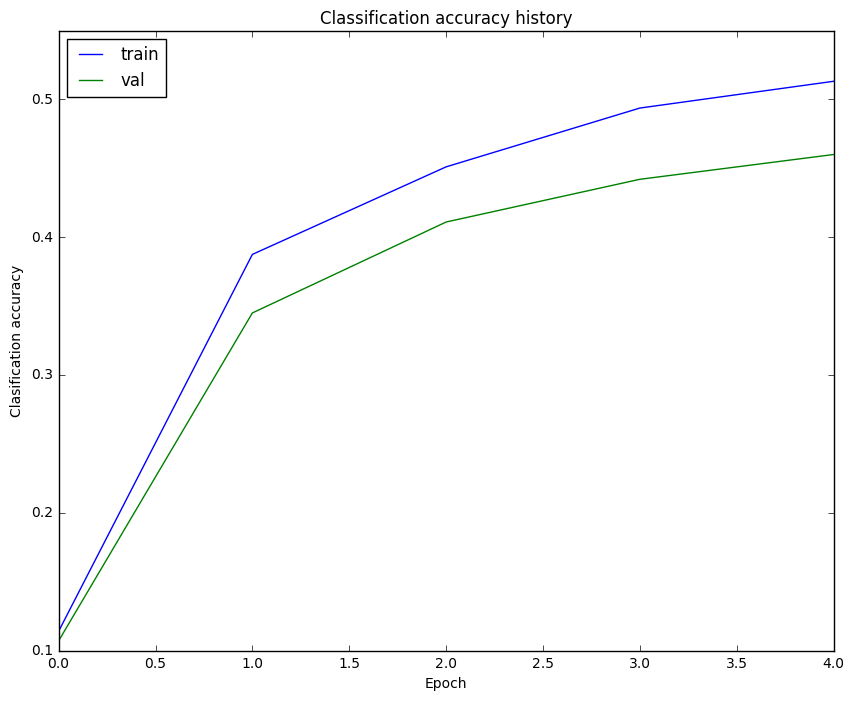

Learning rate:  0.001
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 6.074248
iteration 200 / 1000: loss 1.853848
iteration 300 / 1000: loss 1.651659
iteration 400 / 1000: loss 1.525242
iteration 500 / 1000: loss 1.499516
iteration 600 / 1000: loss 1.567147
iteration 700 / 1000: loss 1.350057
iteration 800 / 1000: loss 1.480104
iteration 900 / 1000: loss 1.459488
Validation accuracy:  0.455


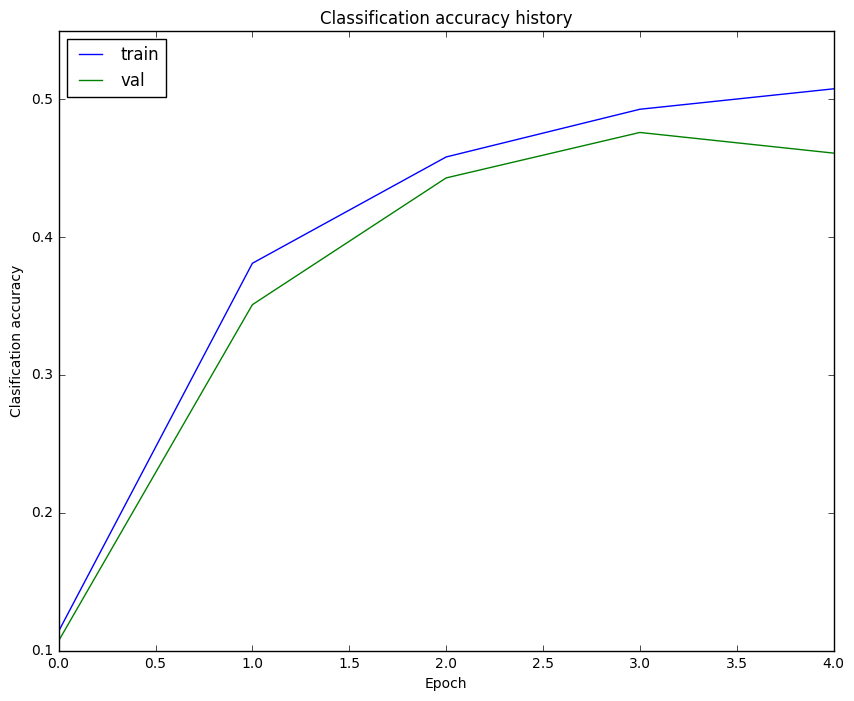

Learning rate:  0.001
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 2.525404
iteration 200 / 1000: loss 1.655751
iteration 300 / 1000: loss 1.688601
iteration 400 / 1000: loss 1.428934
iteration 500 / 1000: loss 1.447411
iteration 600 / 1000: loss 1.571370
iteration 700 / 1000: loss 1.439103
iteration 800 / 1000: loss 1.451172
iteration 900 / 1000: loss 1.429510
Validation accuracy:  0.463


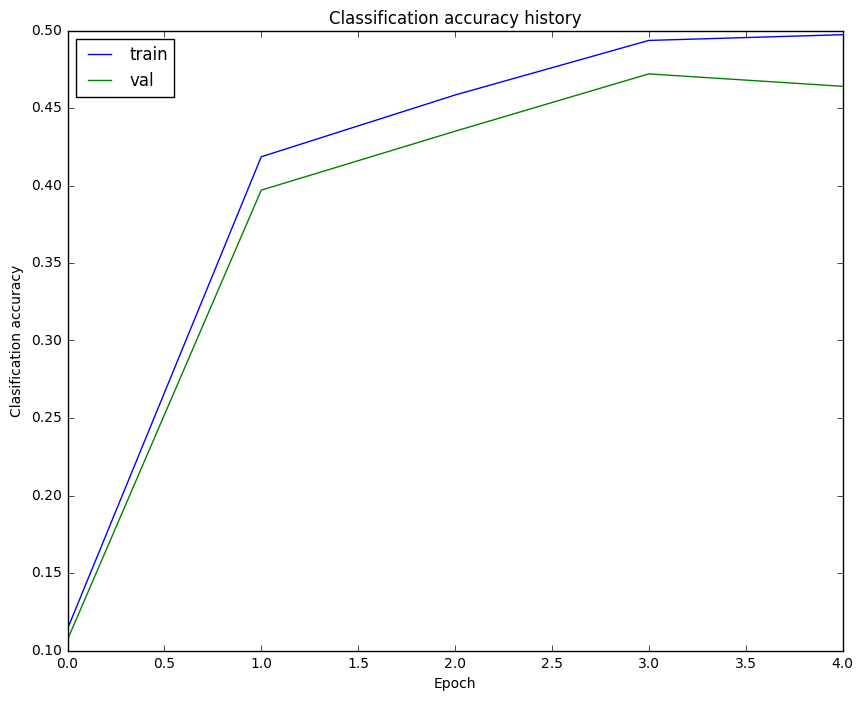

Learning rate:  0.0015
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 2.124718
iteration 200 / 1000: loss 1.648522
iteration 300 / 1000: loss 1.542408
iteration 400 / 1000: loss 1.436699
iteration 500 / 1000: loss 1.438283
iteration 600 / 1000: loss 1.526064
iteration 700 / 1000: loss 1.381359
iteration 800 / 1000: loss 1.357034
iteration 900 / 1000: loss 1.388713
Validation accuracy:  0.467


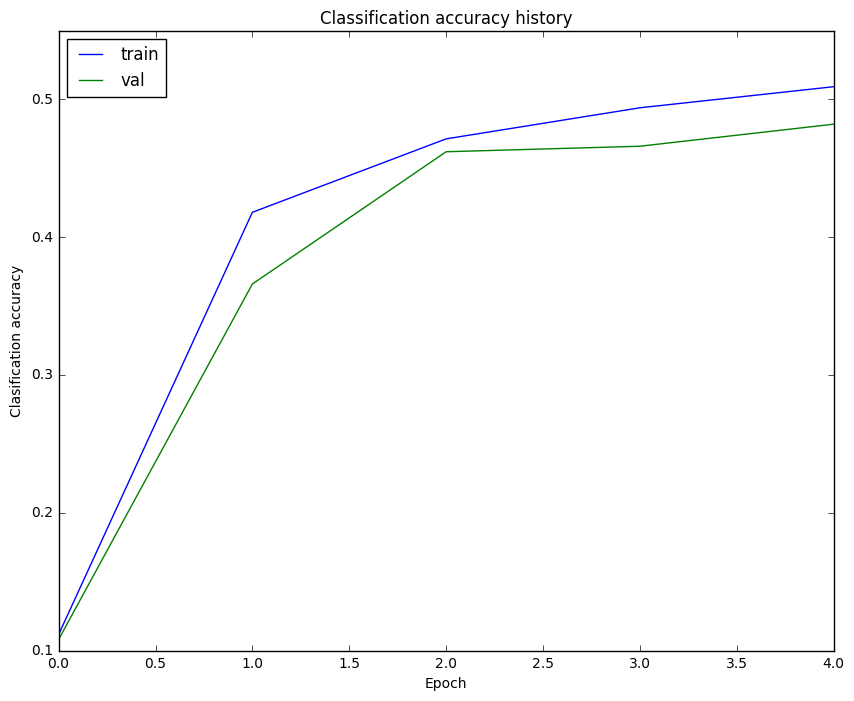

Learning rate:  0.0015
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 2.032967
iteration 200 / 1000: loss 1.583612
iteration 300 / 1000: loss 1.576481
iteration 400 / 1000: loss 1.448448
iteration 500 / 1000: loss 1.430595
iteration 600 / 1000: loss 1.539864
iteration 700 / 1000: loss 1.426212
iteration 800 / 1000: loss 1.370429
iteration 900 / 1000: loss 1.364773
Validation accuracy:  0.472


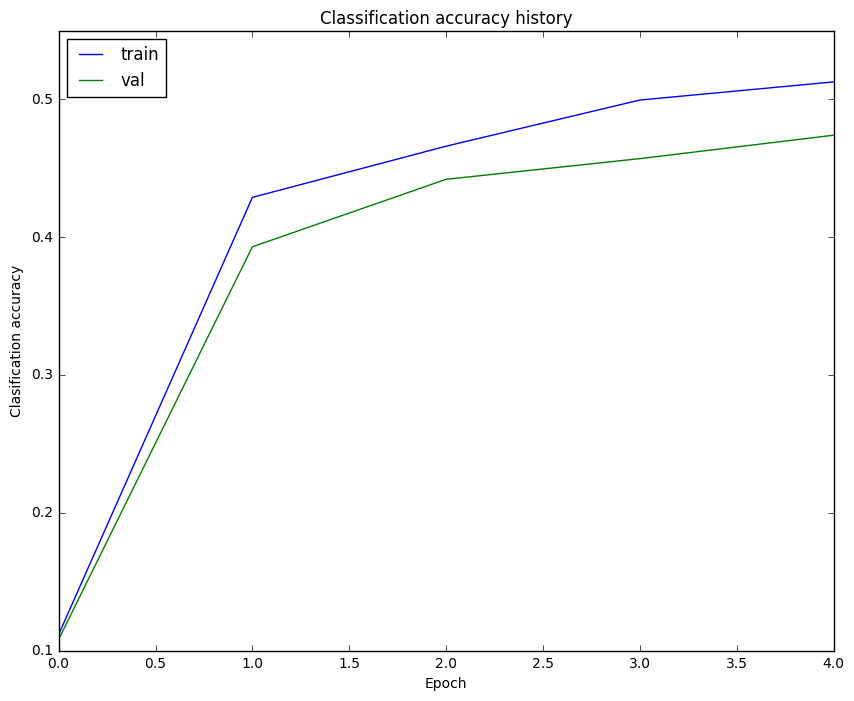

Learning rate:  0.0015
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 1.857392
iteration 200 / 1000: loss 1.524530
iteration 300 / 1000: loss 1.622815
iteration 400 / 1000: loss 1.519145
iteration 500 / 1000: loss 1.390796
iteration 600 / 1000: loss 1.576227
iteration 700 / 1000: loss 1.413844
iteration 800 / 1000: loss 1.371721
iteration 900 / 1000: loss 1.413898
Validation accuracy:  0.452


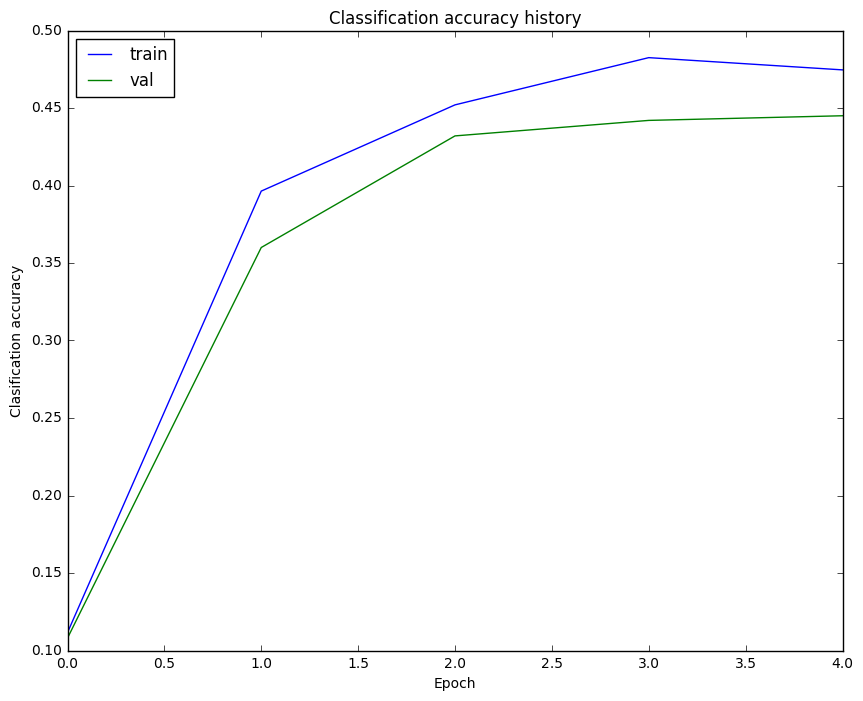

Learning rate:  0.002
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 1.744242
iteration 200 / 1000: loss 1.553149
iteration 300 / 1000: loss 1.584441
iteration 400 / 1000: loss 1.432792
iteration 500 / 1000: loss 1.445344
iteration 600 / 1000: loss 1.526814
iteration 700 / 1000: loss 1.407575
iteration 800 / 1000: loss 1.410683
iteration 900 / 1000: loss 1.373388
Validation accuracy:  0.474


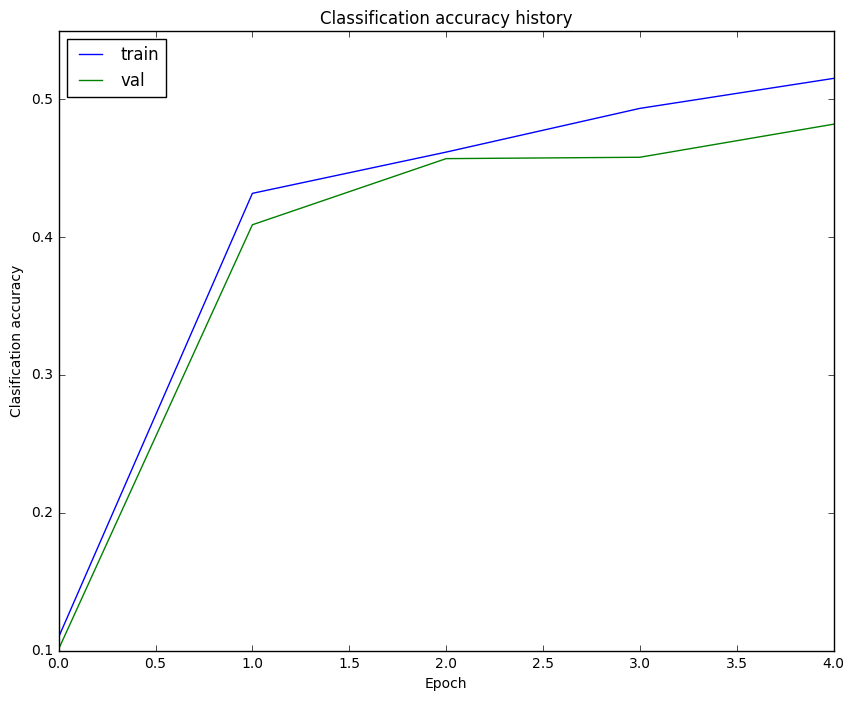

Learning rate:  0.002
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 1.634788
iteration 200 / 1000: loss 1.605771
iteration 300 / 1000: loss 1.565931
iteration 400 / 1000: loss 1.445405
iteration 500 / 1000: loss 1.426254
iteration 600 / 1000: loss 1.508721
iteration 700 / 1000: loss 1.383939
iteration 800 / 1000: loss 1.410046
iteration 900 / 1000: loss 1.361035
Validation accuracy:  0.487


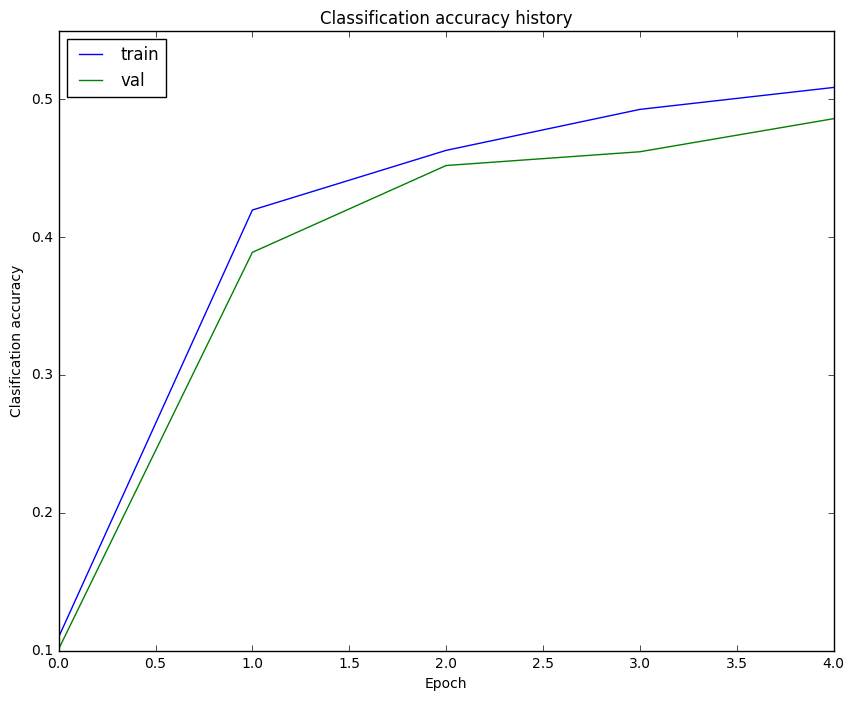

Learning rate:  0.002
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 1.774832
iteration 200 / 1000: loss 1.598440
iteration 300 / 1000: loss 1.644766
iteration 400 / 1000: loss 1.521673
iteration 500 / 1000: loss 1.454766
iteration 600 / 1000: loss 1.573561
iteration 700 / 1000: loss 1.434444
iteration 800 / 1000: loss 1.467795
iteration 900 / 1000: loss 1.410482
Validation accuracy:  0.468


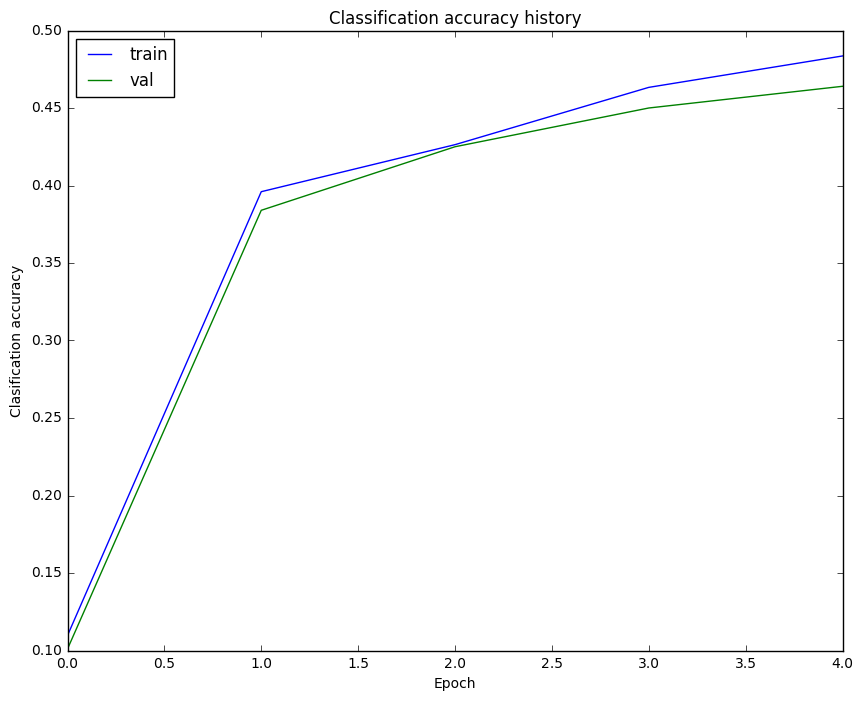

Learning rate:  0.0025
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 1.728006
iteration 200 / 1000: loss 1.549454
iteration 300 / 1000: loss 1.591937
iteration 400 / 1000: loss 1.485950
iteration 500 / 1000: loss 1.435903
iteration 600 / 1000: loss 1.551635
iteration 700 / 1000: loss 1.426492
iteration 800 / 1000: loss 1.340303
iteration 900 / 1000: loss 1.442647
Validation accuracy:  0.474


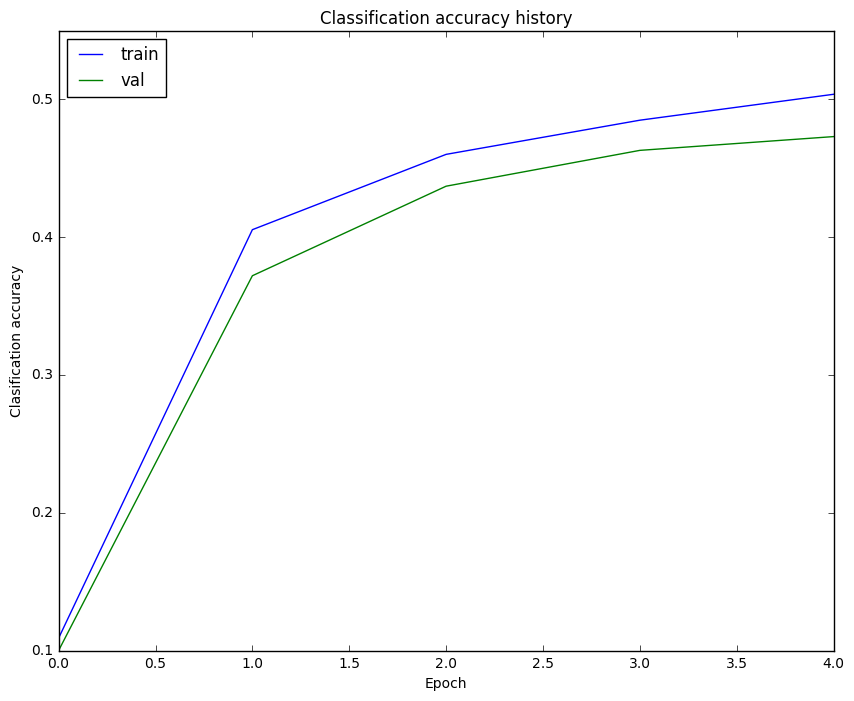

Learning rate:  0.0025
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 1.717764
iteration 200 / 1000: loss 1.605214
iteration 300 / 1000: loss 1.605851
iteration 400 / 1000: loss 1.510111
iteration 500 / 1000: loss 1.428260
iteration 600 / 1000: loss 1.522901
iteration 700 / 1000: loss 1.410857
iteration 800 / 1000: loss 1.337027
iteration 900 / 1000: loss 1.455425
Validation accuracy:  0.479


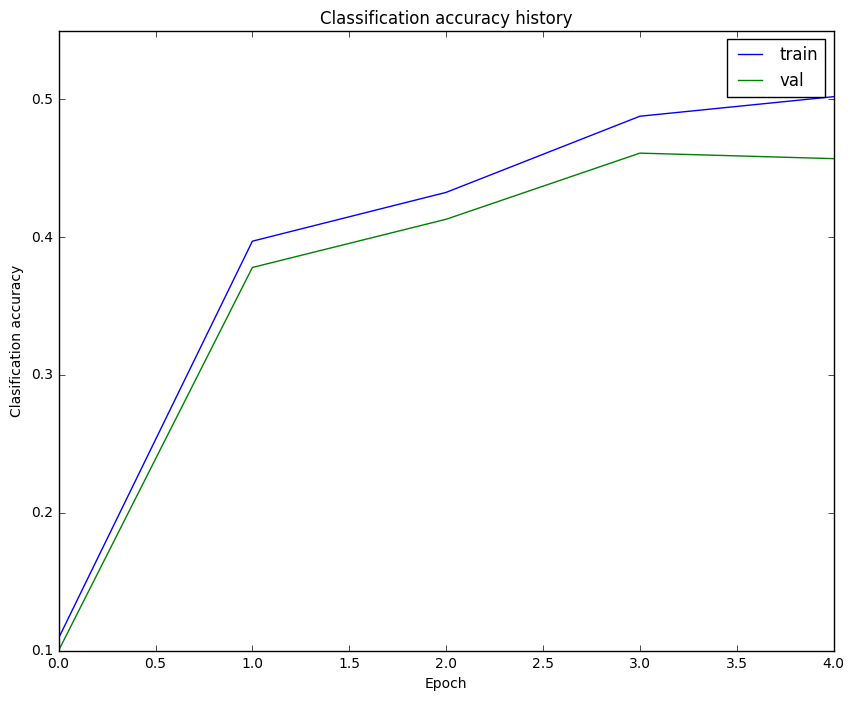

Learning rate:  0.0025
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss 3.784646
iteration 300 / 1000: loss 2.704547
iteration 400 / 1000: loss 1.669538
iteration 500 / 1000: loss 1.676478
iteration 600 / 1000: loss 2.167334
iteration 700 / 1000: loss 1.752695
iteration 800 / 1000: loss 1.675895
iteration 900 / 1000: loss 1.627639
Validation accuracy:  0.404


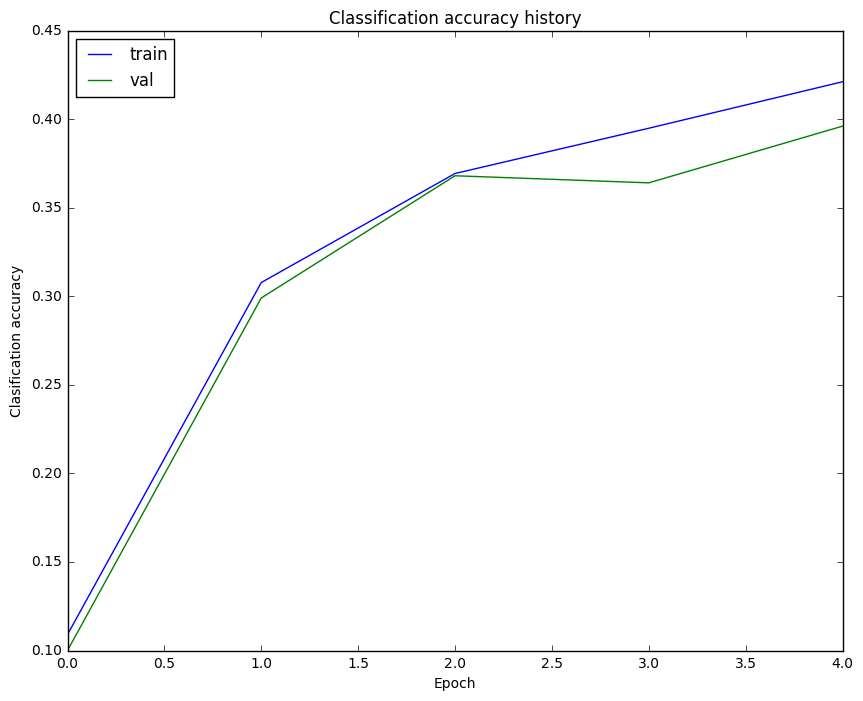

Learning rate:  0.003
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 5.261125
iteration 200 / 1000: loss 1.889414
iteration 300 / 1000: loss 1.681748
iteration 400 / 1000: loss 1.602673
iteration 500 / 1000: loss 1.491926
iteration 600 / 1000: loss 1.617752
iteration 700 / 1000: loss 1.465209
iteration 800 / 1000: loss 1.415939
iteration 900 / 1000: loss 1.457194
Validation accuracy:  0.48


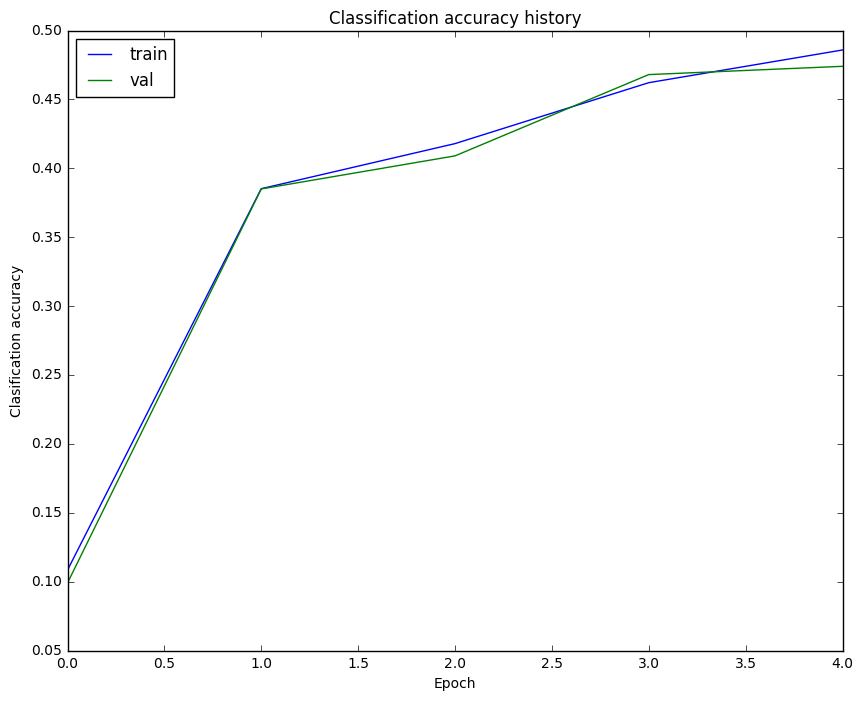

Learning rate:  0.003
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.285


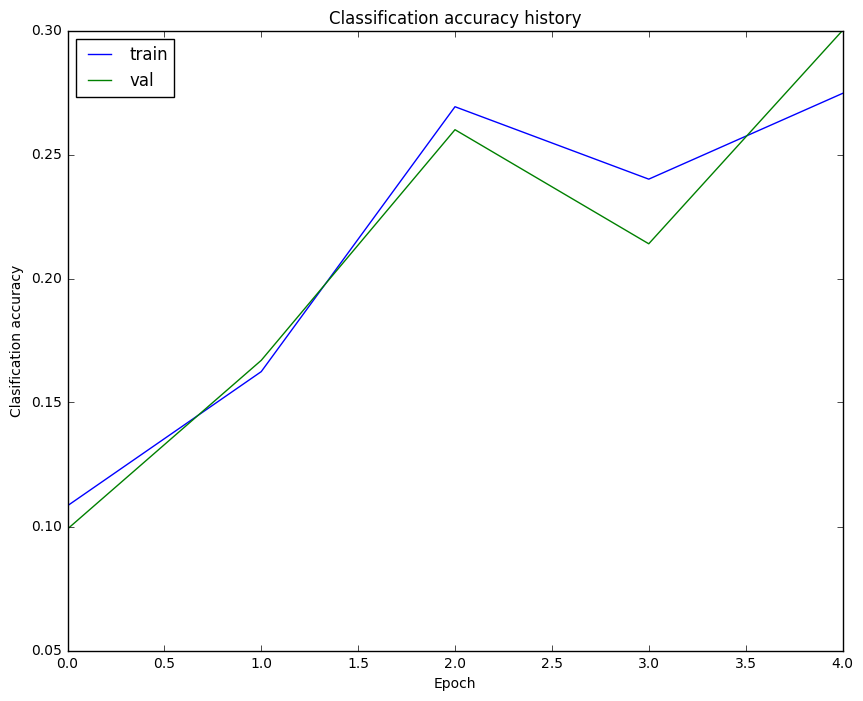

Learning rate:  0.003
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.185


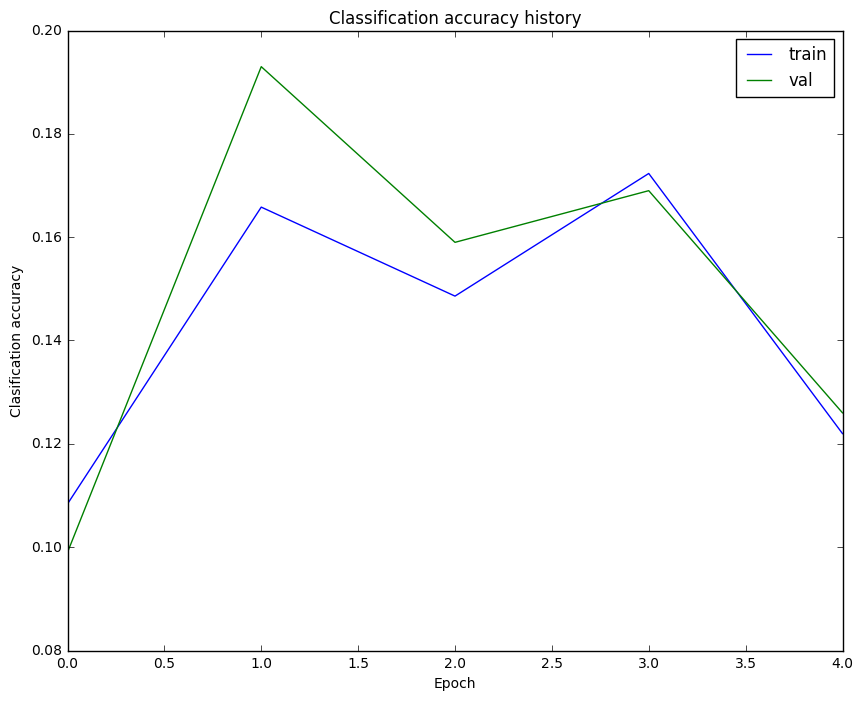

Learning rate:  0.0035
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.272


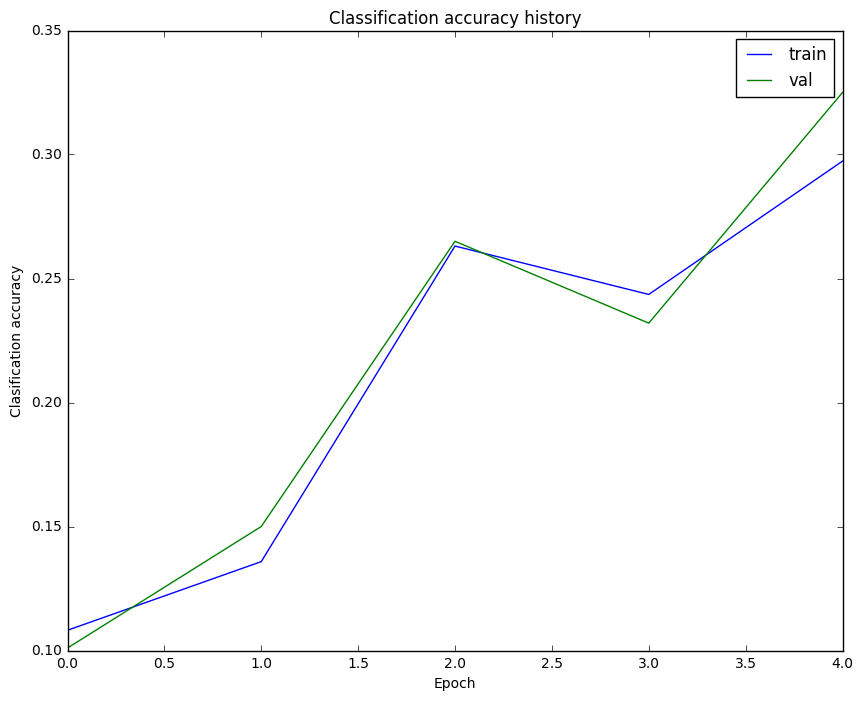

Learning rate:  0.0035
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.285


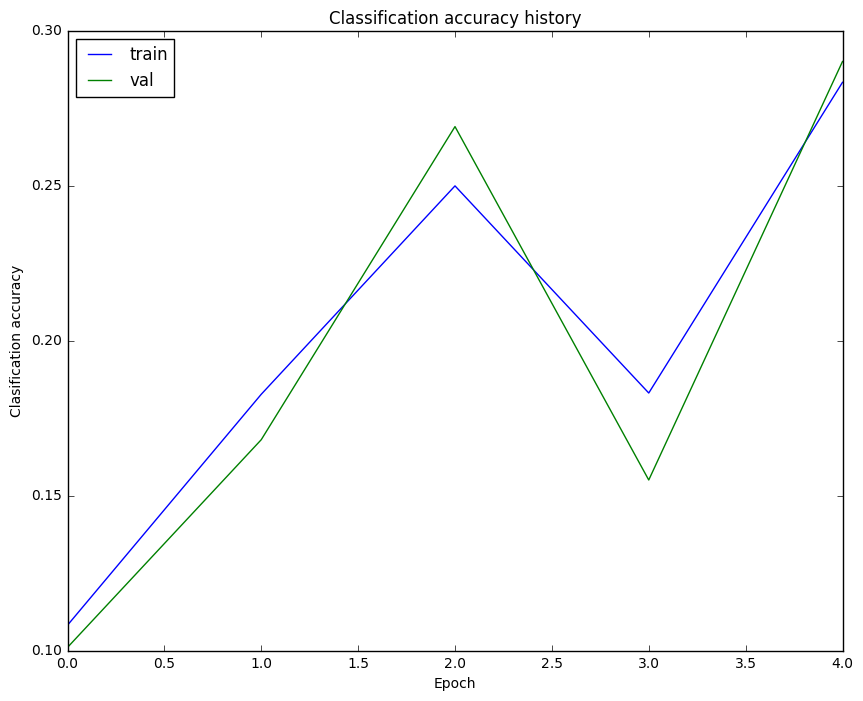

Learning rate:  0.0035
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.133


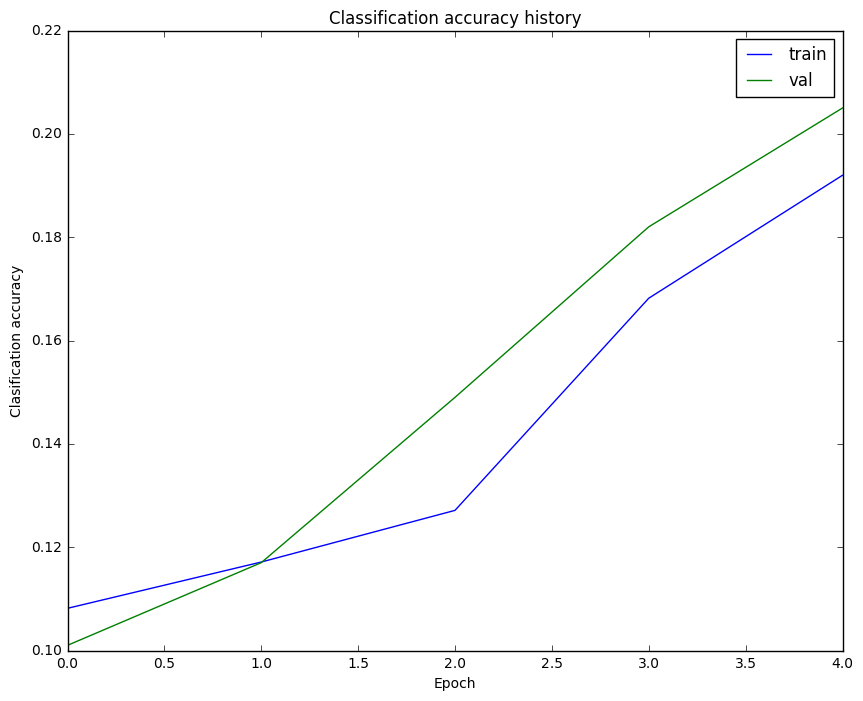

Learning rate:  0.004
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.305


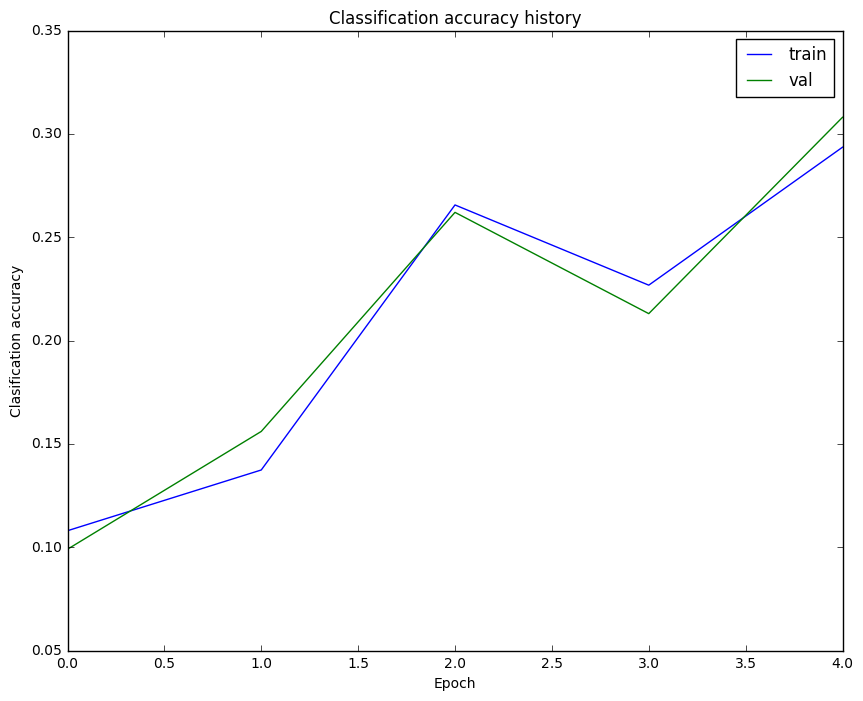

Learning rate:  0.004
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.26


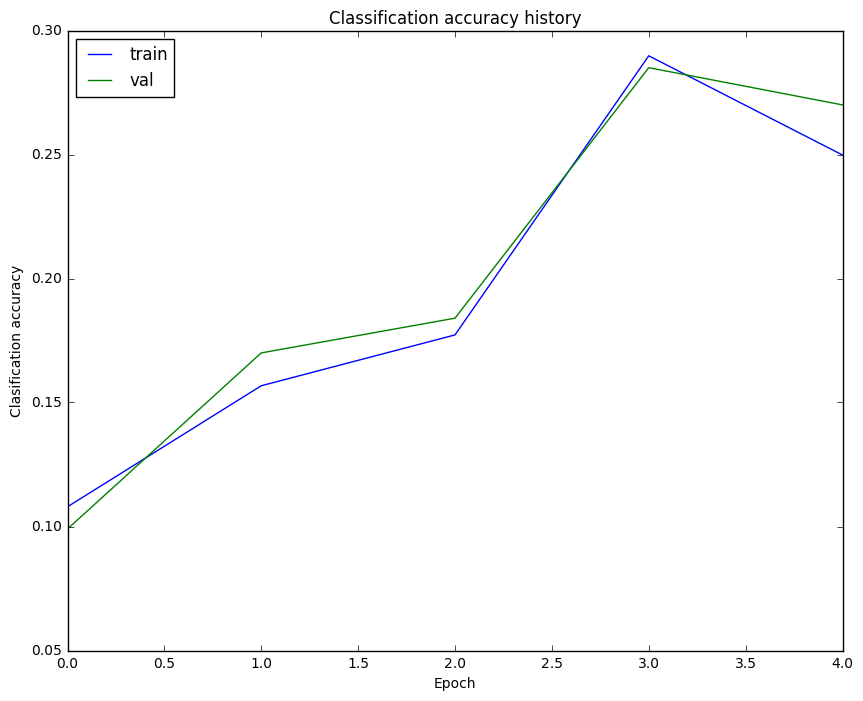

Learning rate:  0.004
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.126


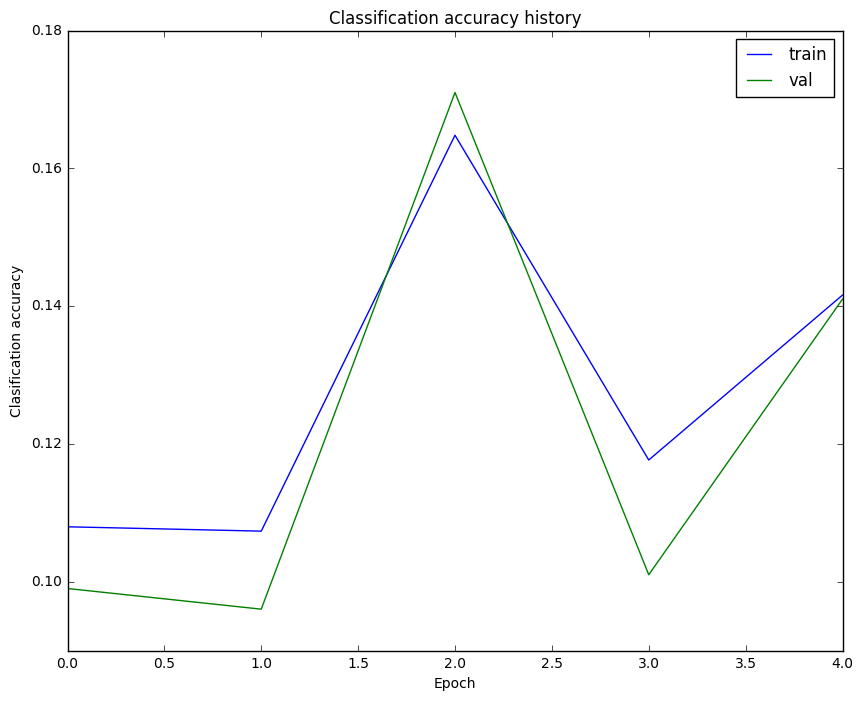

Learning rate:  0.0045
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.225


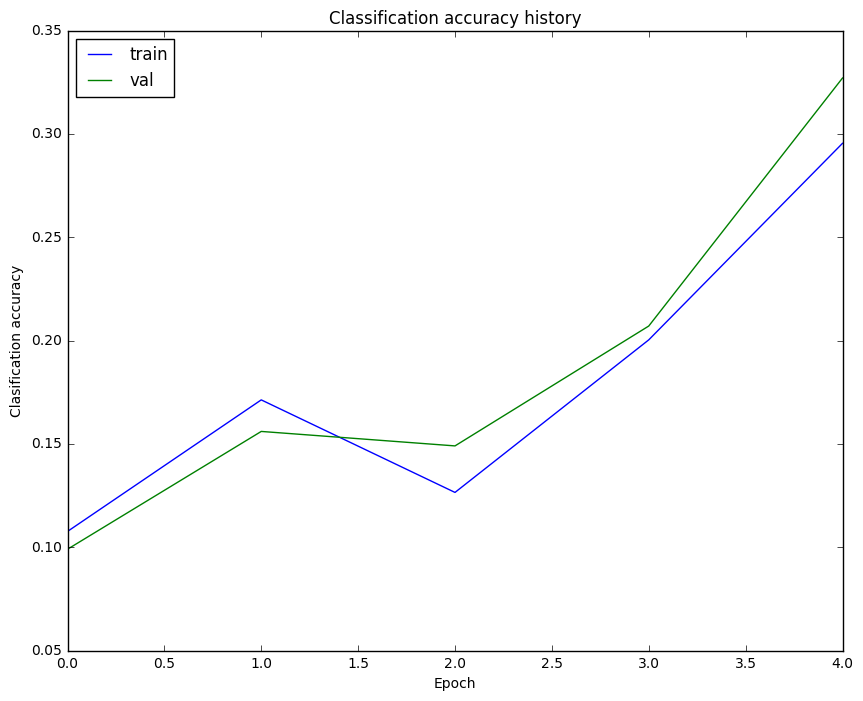

Learning rate:  0.0045
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.247


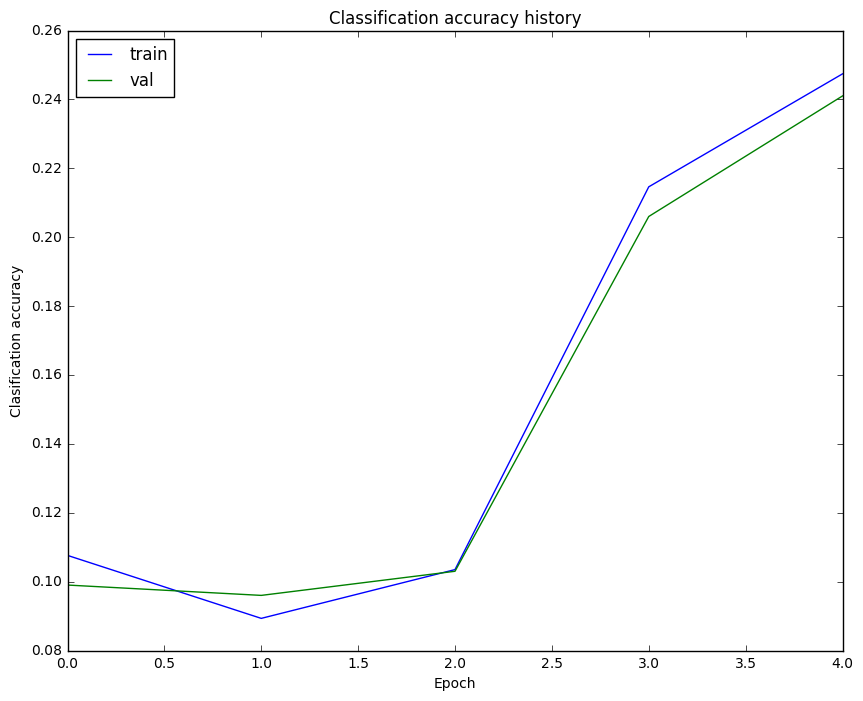

Learning rate:  0.0045
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.126


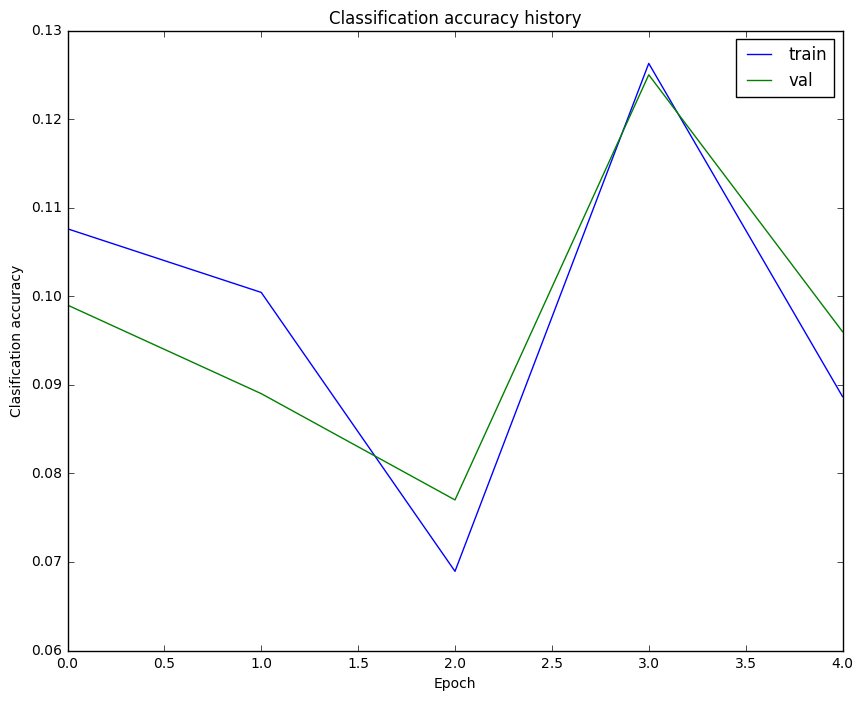

Learning rate:  0.005
Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.234


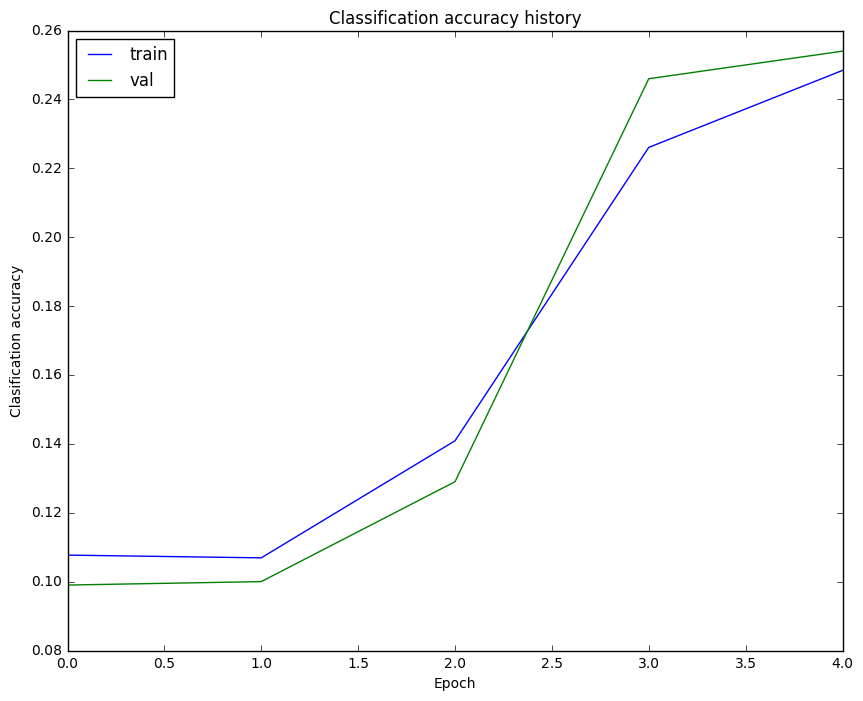

Learning rate:  0.005
Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
Validation accuracy:  0.303


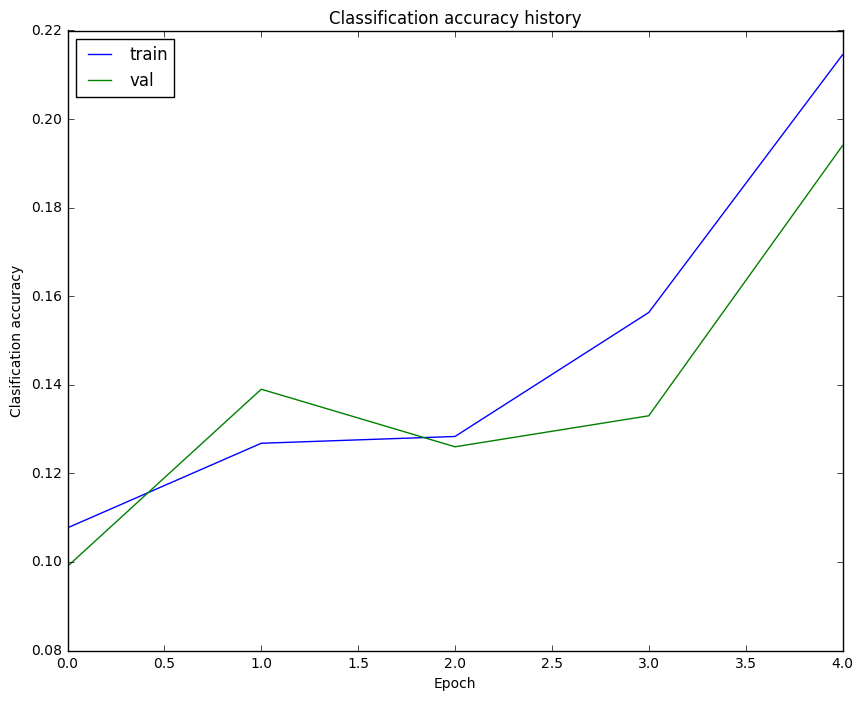

Learning rate:  0.005
Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss nan
Validation accuracy:  0.087


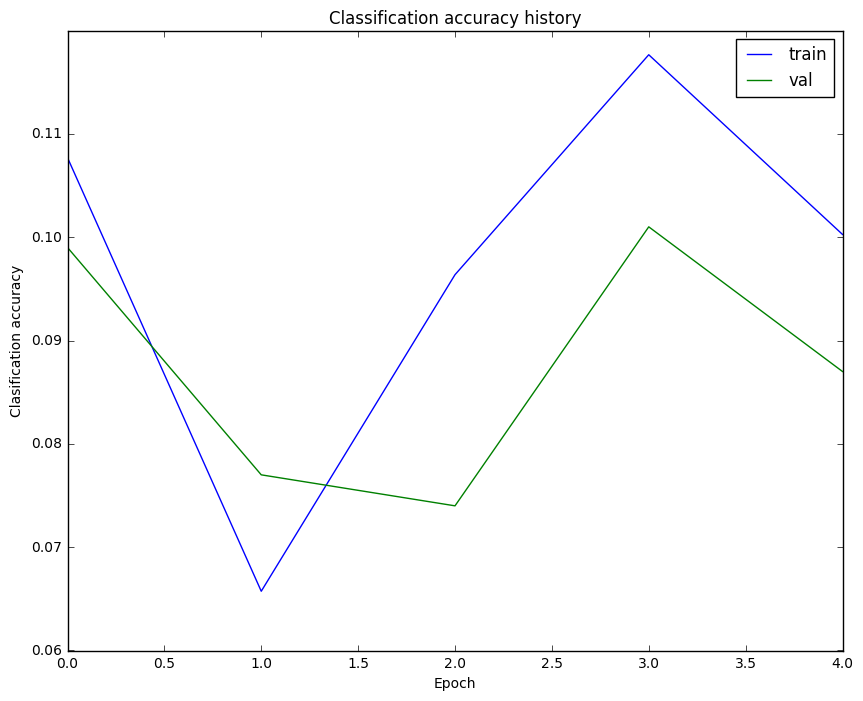

In [11]:
lr = np.linspace(5e-4,5e-3,10)
print lr
lrd = [0.75,0.8,0.95]
for i in lr:
    for j in lrd:
        print "Learning rate: ", i
        print "Learning rate decay: ", j
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=i, learning_rate_decay=j,
            reg=0, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val) == y_val).mean()
        print 'Validation accuracy: ', val_acc
    
        plt.plot(stats['train_acc_history'], label='train')
        plt.plot(stats['val_acc_history'], label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Clasification accuracy')
        plt.legend(loc="best")
        plt.show()


## Learning rate Decay : 
  When we iterated over the decay rate from 0.5 to 0.95 the accuracy value varried and when the value of learning 
  rate decay is around 0.75 we found the highest accuracy. 
                 So, we use the value 0.95 is a better learning_rate decay parameter.

Learning rate decay:  0.5
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.616518
iteration 200 / 1000: loss 2.848051
iteration 300 / 1000: loss 1.734643
iteration 400 / 1000: loss 1.506651
iteration 500 / 1000: loss 1.588854
iteration 600 / 1000: loss 1.694193
iteration 700 / 1000: loss 1.515557
iteration 800 / 1000: loss 1.428044
iteration 900 / 1000: loss 1.397831
Validation accuracy:  0.424


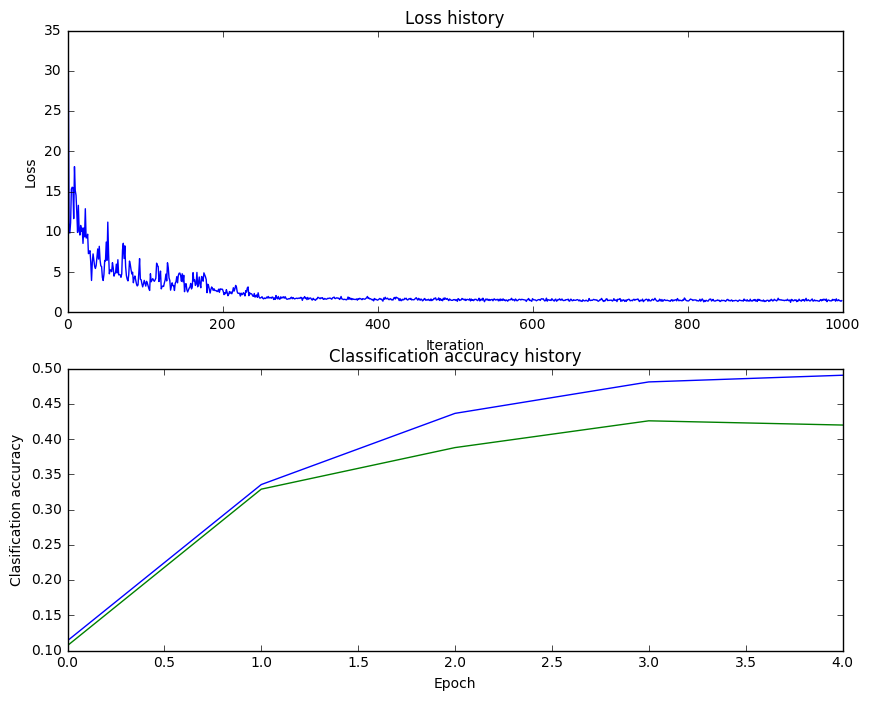

Learning rate decay:  0.55
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 2.860436
iteration 200 / 1000: loss 2.488028
iteration 300 / 1000: loss 1.691611
iteration 400 / 1000: loss 1.560264
iteration 500 / 1000: loss 1.633497
iteration 600 / 1000: loss 1.588905
iteration 700 / 1000: loss 1.421511
iteration 800 / 1000: loss 1.484126
iteration 900 / 1000: loss 1.426670
Validation accuracy:  0.451


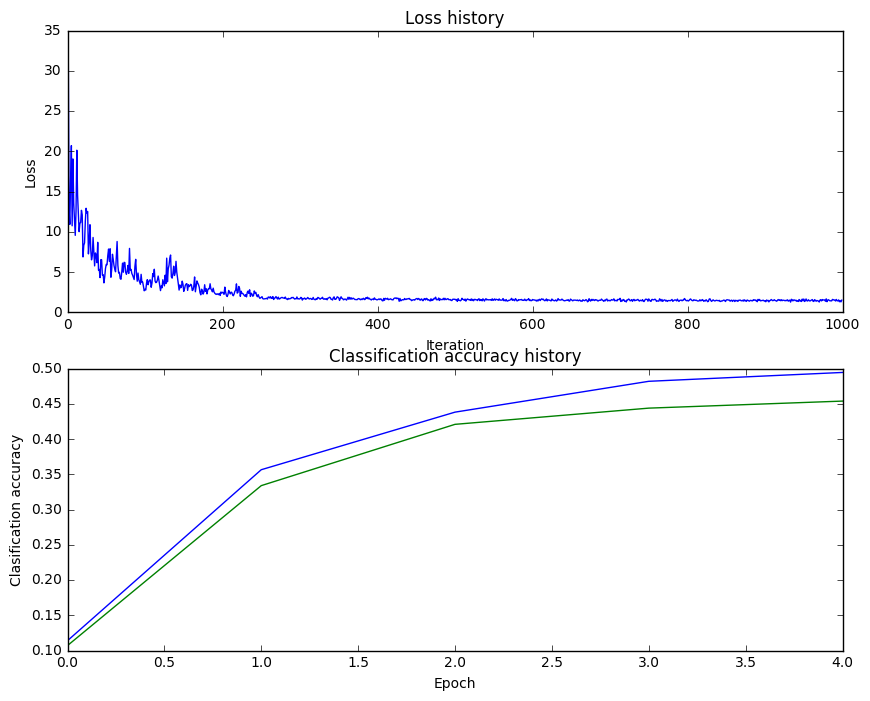

Learning rate decay:  0.6
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.103596
iteration 200 / 1000: loss 2.222320
iteration 300 / 1000: loss 1.770769
iteration 400 / 1000: loss 1.493776
iteration 500 / 1000: loss 1.584849
iteration 600 / 1000: loss 1.627021
iteration 700 / 1000: loss 1.439404
iteration 800 / 1000: loss 1.421783
iteration 900 / 1000: loss 1.451495
Validation accuracy:  0.47


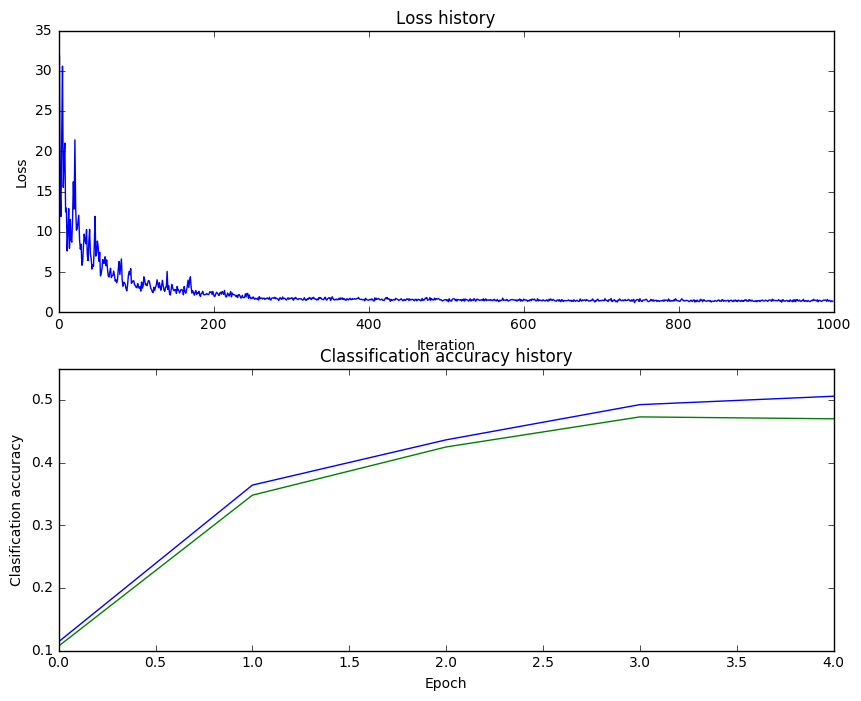

Learning rate decay:  0.65
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 4.297221
iteration 200 / 1000: loss 2.025333
iteration 300 / 1000: loss 1.757152
iteration 400 / 1000: loss 1.542283
iteration 500 / 1000: loss 1.429452
iteration 600 / 1000: loss 1.533063
iteration 700 / 1000: loss 1.465538
iteration 800 / 1000: loss 1.418007
iteration 900 / 1000: loss 1.350163
Validation accuracy:  0.454


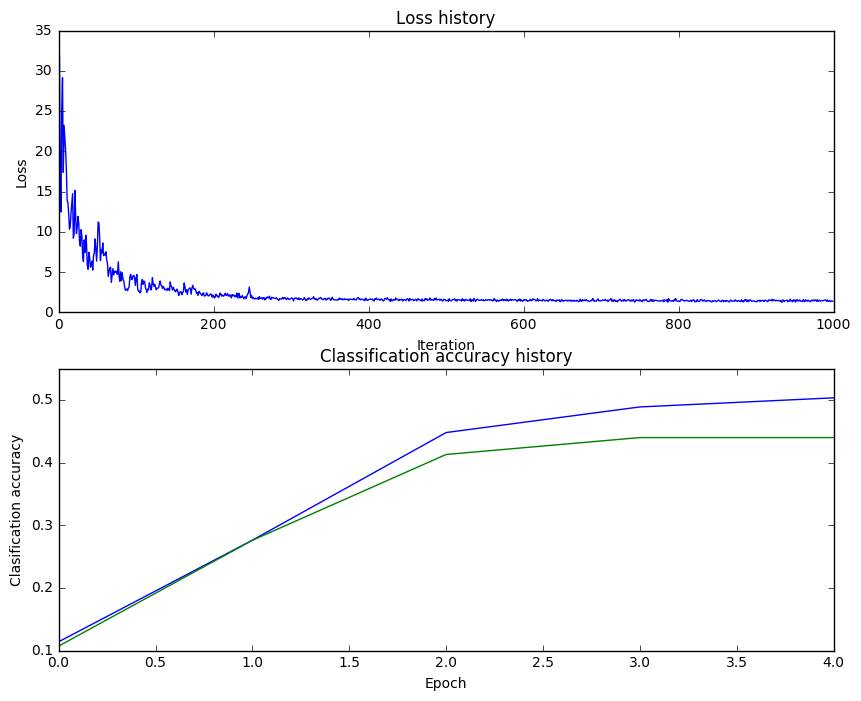

Learning rate decay:  0.7
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 4.087117
iteration 200 / 1000: loss 2.075379
iteration 300 / 1000: loss 1.793025
iteration 400 / 1000: loss 1.539937
iteration 500 / 1000: loss 1.536551
iteration 600 / 1000: loss 1.643114
iteration 700 / 1000: loss 1.429169
iteration 800 / 1000: loss 1.379220
iteration 900 / 1000: loss 1.379726
Validation accuracy:  0.45


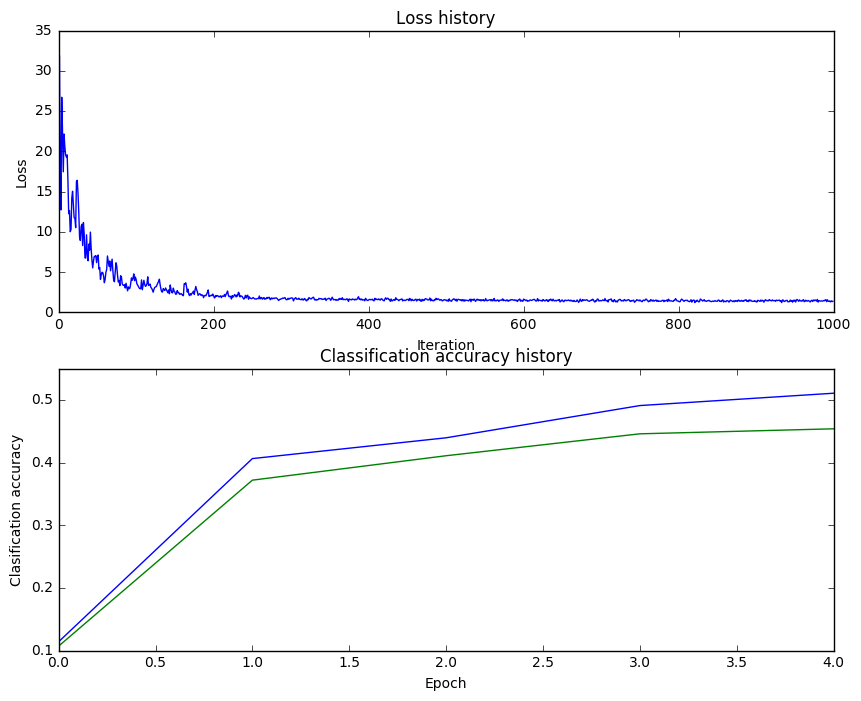

Learning rate decay:  0.75
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.362779
iteration 200 / 1000: loss 2.169300
iteration 300 / 1000: loss 1.725820
iteration 400 / 1000: loss 1.499691
iteration 500 / 1000: loss 1.475233
iteration 600 / 1000: loss 1.578761
iteration 700 / 1000: loss 1.436312
iteration 800 / 1000: loss 1.412826
iteration 900 / 1000: loss 1.381989
Validation accuracy:  0.44


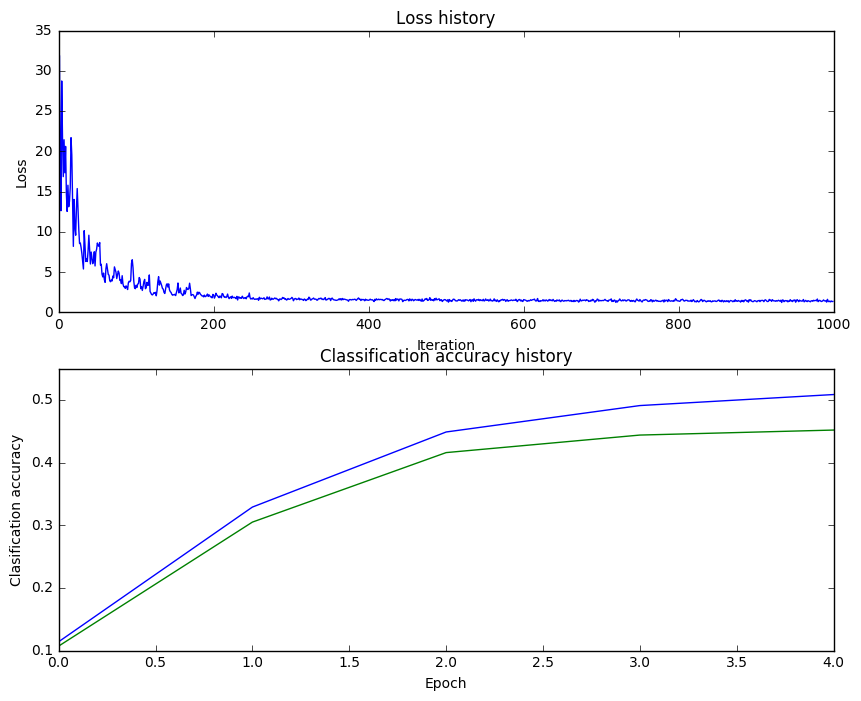

Learning rate decay:  0.8
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 6.061515
iteration 200 / 1000: loss 1.804292
iteration 300 / 1000: loss 1.659008
iteration 400 / 1000: loss 1.513673
iteration 500 / 1000: loss 1.464522
iteration 600 / 1000: loss 1.559166
iteration 700 / 1000: loss 1.397192
iteration 800 / 1000: loss 1.469651
iteration 900 / 1000: loss 1.466978
Validation accuracy:  0.472


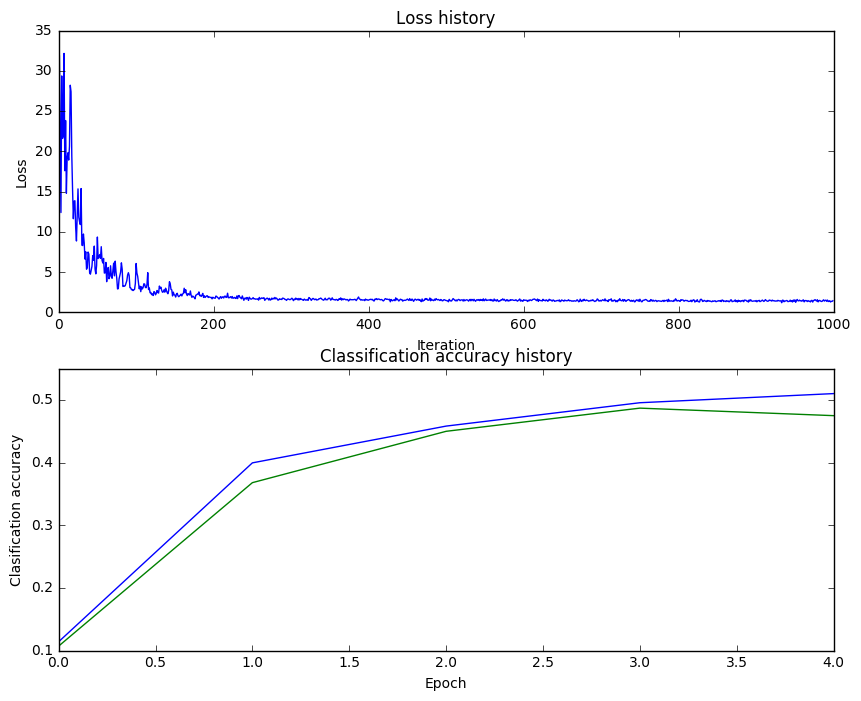

Learning rate decay:  0.85
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 3.023166
iteration 200 / 1000: loss 1.820112
iteration 300 / 1000: loss 1.650052
iteration 400 / 1000: loss 1.470858
iteration 500 / 1000: loss 1.469794
iteration 600 / 1000: loss 1.548370
iteration 700 / 1000: loss 1.413326
iteration 800 / 1000: loss 1.413833
iteration 900 / 1000: loss 1.419966
Validation accuracy:  0.457


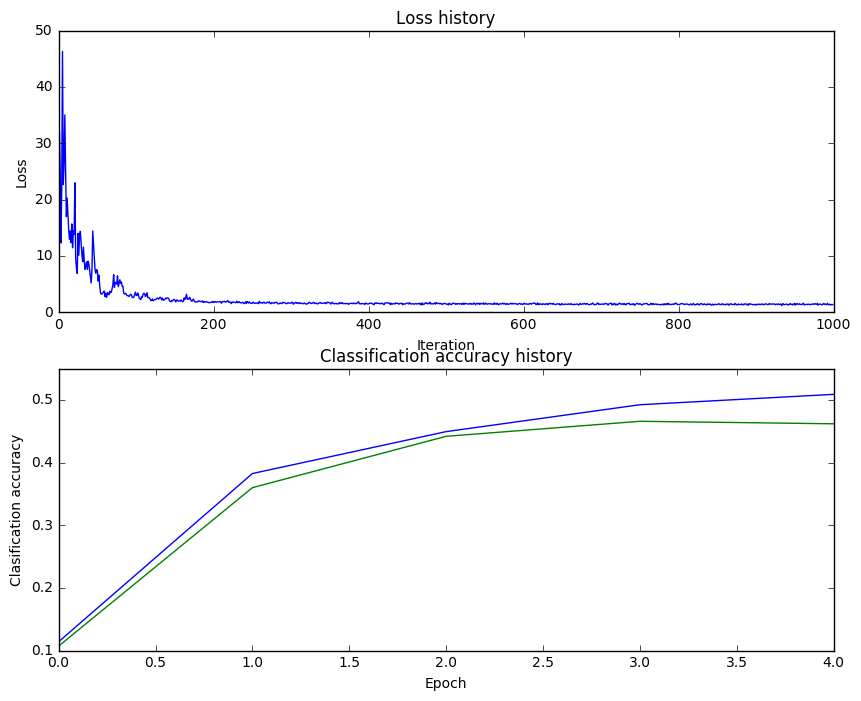

Learning rate decay:  0.9
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 2.427409
iteration 200 / 1000: loss 1.660647
iteration 300 / 1000: loss 1.700693
iteration 400 / 1000: loss 1.507640
iteration 500 / 1000: loss 1.513860
iteration 600 / 1000: loss 1.551545
iteration 700 / 1000: loss 1.450024
iteration 800 / 1000: loss 1.378007
iteration 900 / 1000: loss 1.453944
Validation accuracy:  0.465


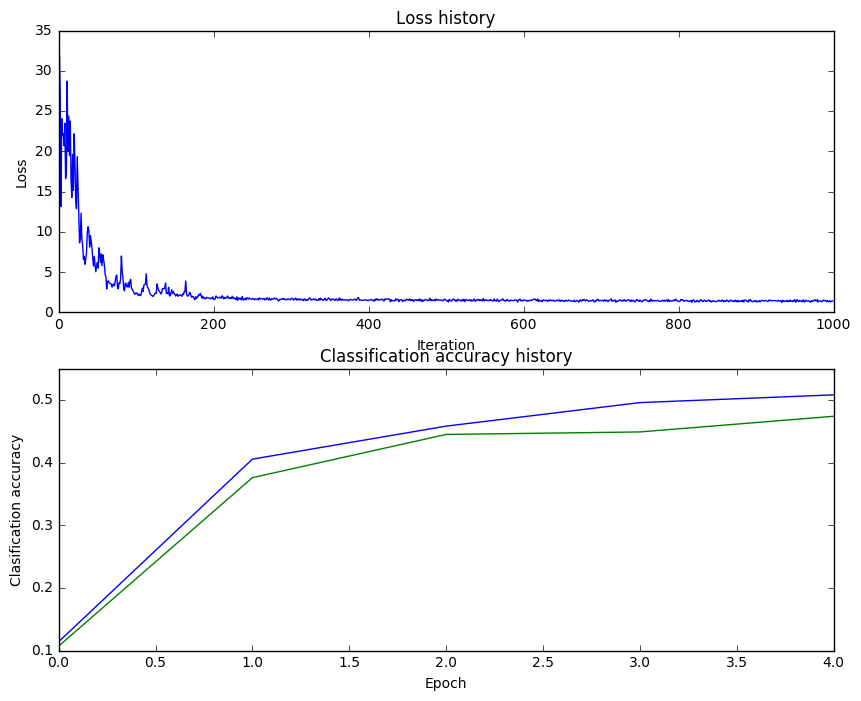

Learning rate decay:  0.95
iteration 0 / 1000: loss 5.338326
iteration 100 / 1000: loss 2.525407
iteration 200 / 1000: loss 1.638456
iteration 300 / 1000: loss 1.633076
iteration 400 / 1000: loss 1.438704
iteration 500 / 1000: loss 1.452840
iteration 600 / 1000: loss 1.583579
iteration 700 / 1000: loss 1.448021
iteration 800 / 1000: loss 1.446465
iteration 900 / 1000: loss 1.444335
Validation accuracy:  0.463


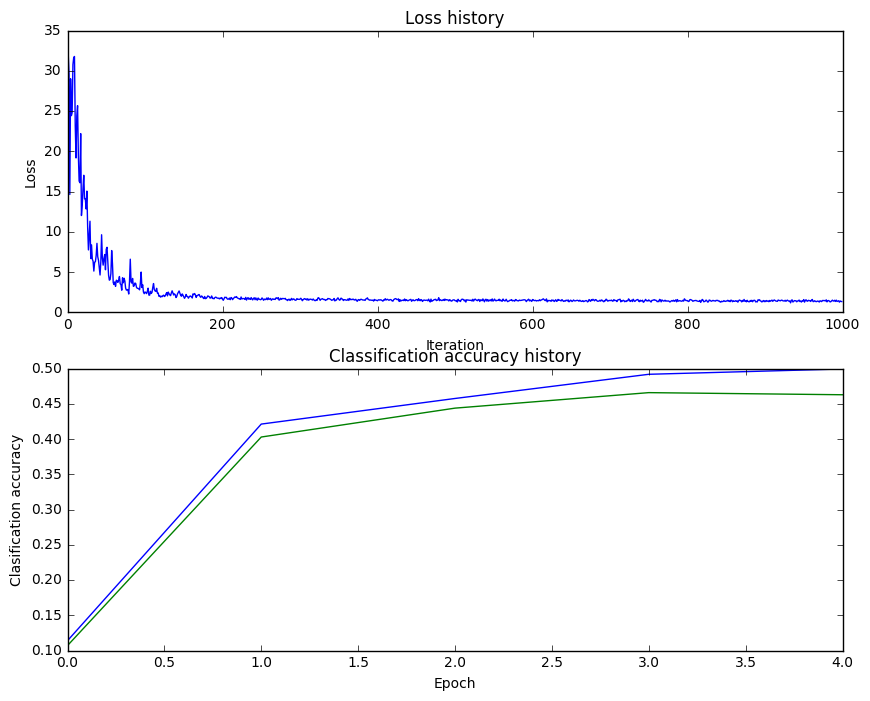

In [6]:
lrd = np.arange(0.5,1,0.05)
for i in lrd:
    print "Learning rate decay: ", i
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-3, learning_rate_decay=i,
            reg=0, verbose=True)

    # Predict on the validation set
    val_acc = (net.predict(X_val) == y_val).mean()
    print 'Validation accuracy: ', val_acc
    
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()


batch size:  100
iteration 0 / 1000: loss 5.929757
iteration 100 / 1000: loss 3.321205
iteration 200 / 1000: loss 2.265472
iteration 300 / 1000: loss 2.162366
iteration 400 / 1000: loss 1.985954
iteration 500 / 1000: loss 2.002558
iteration 600 / 1000: loss 1.843615
iteration 700 / 1000: loss 1.849705
iteration 800 / 1000: loss 1.810444
iteration 900 / 1000: loss 1.782196
Validation accuracy:  0.452


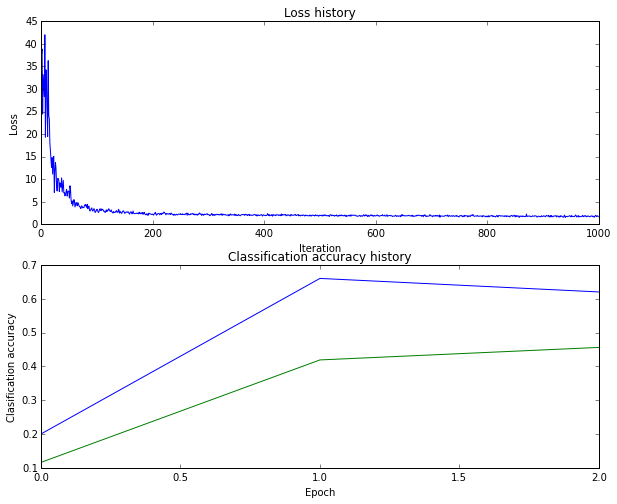

batch size:  200
iteration 0 / 1000: loss 1.720484
iteration 100 / 1000: loss 1.755715
iteration 200 / 1000: loss 1.704621
iteration 300 / 1000: loss 1.601263
iteration 400 / 1000: loss 1.644029
iteration 500 / 1000: loss 1.679817
iteration 600 / 1000: loss 1.610520
iteration 700 / 1000: loss 1.489752
iteration 800 / 1000: loss 1.624665
iteration 900 / 1000: loss 1.665158
Validation accuracy:  0.493


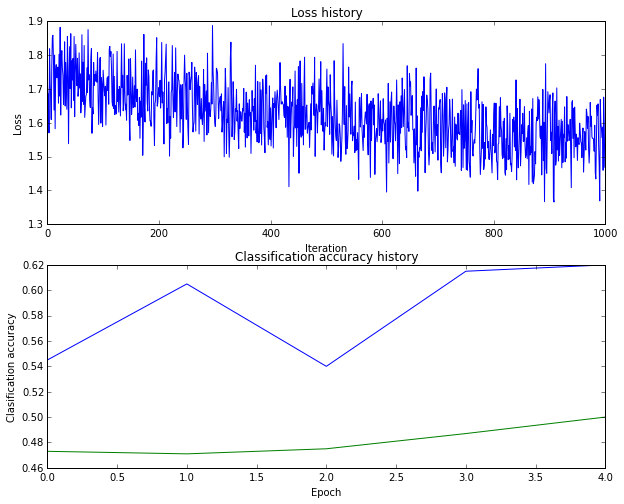

batch size:  300
iteration 0 / 1000: loss 1.550233
iteration 100 / 1000: loss 1.592706
iteration 200 / 1000: loss 1.519326
iteration 300 / 1000: loss 1.558780
iteration 400 / 1000: loss 1.471279
iteration 500 / 1000: loss 1.528087
iteration 600 / 1000: loss 1.448647
iteration 700 / 1000: loss 1.430778
iteration 800 / 1000: loss 1.517282
iteration 900 / 1000: loss 1.482178
Validation accuracy:  0.509


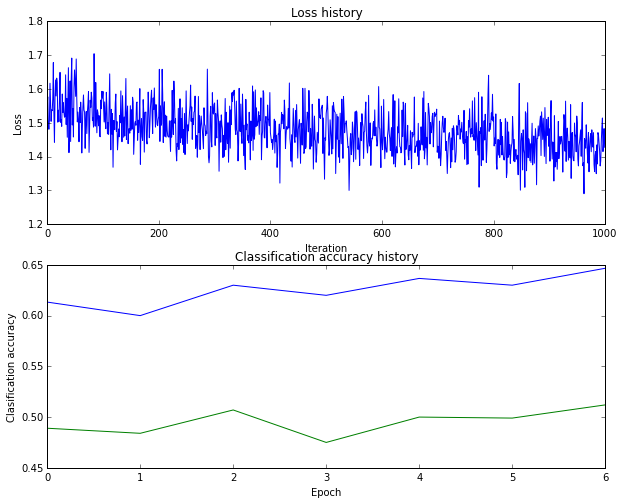

batch size:  400
iteration 0 / 1000: loss 1.397013
iteration 100 / 1000: loss 1.423915
iteration 200 / 1000: loss 1.523833
iteration 300 / 1000: loss 1.479980
iteration 400 / 1000: loss 1.368748
iteration 500 / 1000: loss 1.369981
iteration 600 / 1000: loss 1.468219
iteration 700 / 1000: loss 1.327332
iteration 800 / 1000: loss 1.451277
iteration 900 / 1000: loss 1.411157
Validation accuracy:  0.505


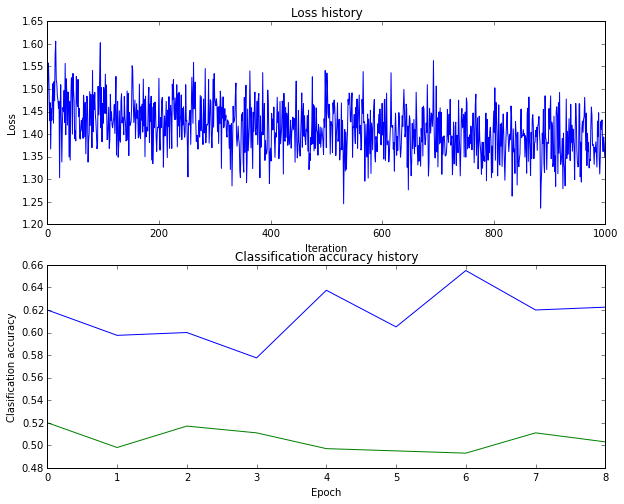

batch size:  500
iteration 0 / 1000: loss 1.435138
iteration 100 / 1000: loss 1.424538
iteration 200 / 1000: loss 1.422205
iteration 300 / 1000: loss 1.373562
iteration 400 / 1000: loss 1.409101
iteration 500 / 1000: loss 1.316591
iteration 600 / 1000: loss 1.307551
iteration 700 / 1000: loss 1.352180
iteration 800 / 1000: loss 1.377443
iteration 900 / 1000: loss 1.395591
Validation accuracy:  0.519


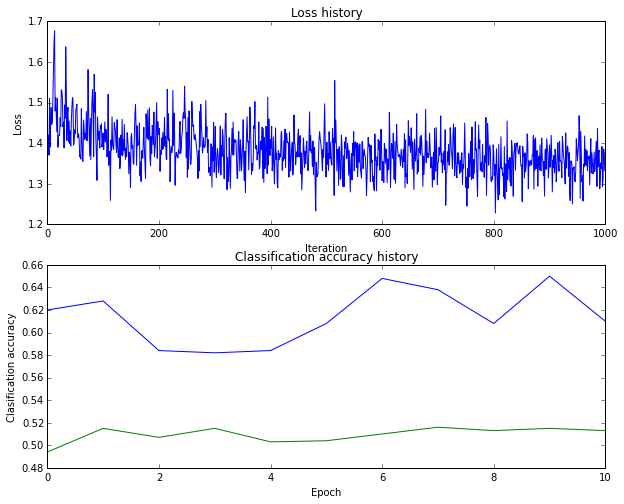

batch size:  600
iteration 0 / 1000: loss 1.370561
iteration 100 / 1000: loss 1.419937
iteration 200 / 1000: loss 1.297532
iteration 300 / 1000: loss 1.373931
iteration 400 / 1000: loss 1.289830
iteration 500 / 1000: loss 1.341369
iteration 600 / 1000: loss 1.367224
iteration 700 / 1000: loss 1.291045
iteration 800 / 1000: loss 1.387093
iteration 900 / 1000: loss 1.305402
Validation accuracy:  0.513


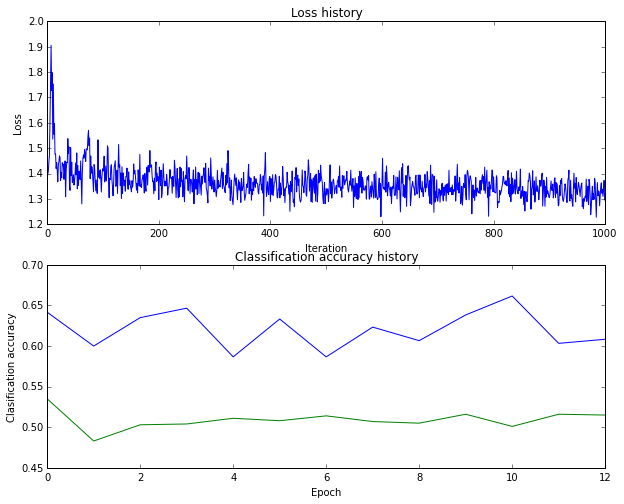

In [9]:
# From below readings we can see a batch size of both 200 & 300 are good!

b_size = np.arange(100,700,100)
for b in b_size:
    print "batch size: ", b
    net = TwoLayerNet(input_size, hidden_size, num_classes) 
    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=b,
            learning_rate=25e-4, learning_rate_decay=0.75,
            reg=0.5, verbose=True)

    # Predict on the validation set
    val_acc = (net.predict(X_val) == y_val).mean()
    print 'Validation accuracy: ', val_acc
    
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()

iterations:  1000
iteration 0 / 1000: loss 1.407045
iteration 100 / 1000: loss 1.479426
iteration 200 / 1000: loss 1.365797
iteration 300 / 1000: loss 1.402487
iteration 400 / 1000: loss 1.347408
iteration 500 / 1000: loss 1.446329
iteration 600 / 1000: loss 1.533486
iteration 700 / 1000: loss 1.403156
iteration 800 / 1000: loss 1.334347
iteration 900 / 1000: loss 1.366721
Validation accuracy:  0.51


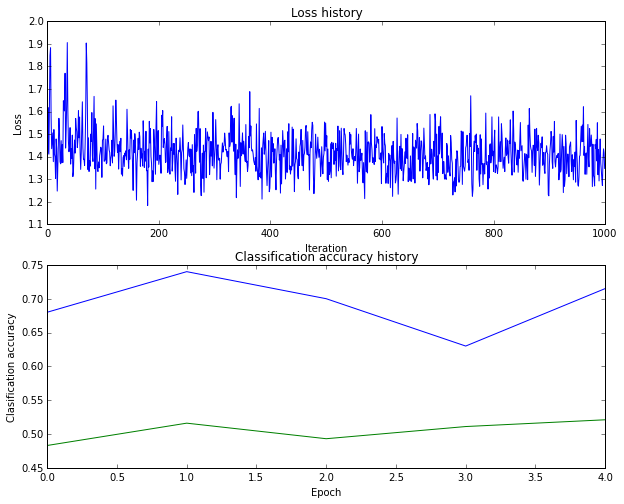

iterations:  1100
iteration 0 / 1100: loss 1.328070
iteration 100 / 1100: loss 1.486931
iteration 200 / 1100: loss 1.322582
iteration 300 / 1100: loss 1.427485
iteration 400 / 1100: loss 1.448039
iteration 500 / 1100: loss 1.511856
iteration 600 / 1100: loss 1.350767
iteration 700 / 1100: loss 1.415391
iteration 800 / 1100: loss 1.365323
iteration 900 / 1100: loss 1.449498
iteration 1000 / 1100: loss 1.333653
Validation accuracy:  0.48


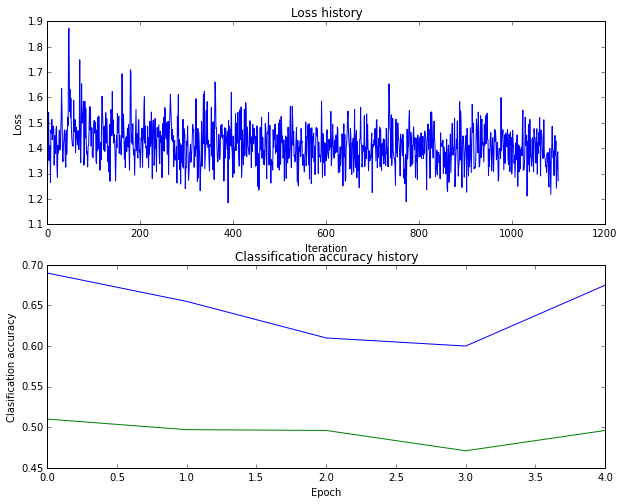

iterations:  1200
iteration 0 / 1200: loss 1.419281
iteration 100 / 1200: loss 1.346177
iteration 200 / 1200: loss 1.425845
iteration 300 / 1200: loss 1.382048
iteration 400 / 1200: loss 1.453091
iteration 500 / 1200: loss 1.286728
iteration 600 / 1200: loss 1.316486
iteration 700 / 1200: loss 1.478464
iteration 800 / 1200: loss 1.508242
iteration 900 / 1200: loss 1.291760
iteration 1000 / 1200: loss 1.352394
iteration 1100 / 1200: loss 1.293046
Validation accuracy:  0.493


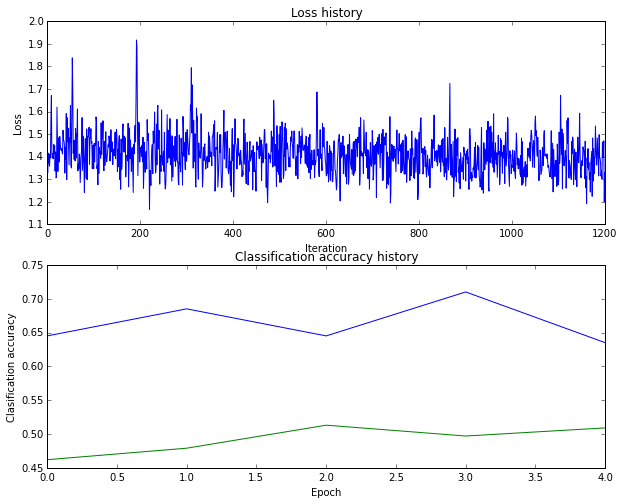

iterations:  1300
iteration 0 / 1300: loss 1.337499
iteration 100 / 1300: loss 1.515258
iteration 200 / 1300: loss 1.419297
iteration 300 / 1300: loss 1.308103
iteration 400 / 1300: loss 1.309049
iteration 500 / 1300: loss 1.253947
iteration 600 / 1300: loss 1.462653
iteration 700 / 1300: loss 1.440054
iteration 800 / 1300: loss 1.442402
iteration 900 / 1300: loss 1.427106
iteration 1000 / 1300: loss 1.324966
iteration 1100 / 1300: loss 1.315956
iteration 1200 / 1300: loss 1.311298
Validation accuracy:  0.524


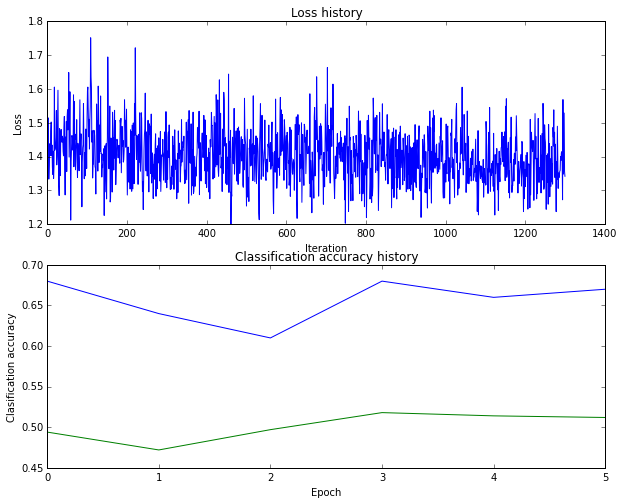

iterations:  1400
iteration 0 / 1400: loss 1.182244
iteration 100 / 1400: loss 1.434038
iteration 200 / 1400: loss 1.366508
iteration 300 / 1400: loss 1.380937
iteration 400 / 1400: loss 1.478716
iteration 500 / 1400: loss 1.460895
iteration 600 / 1400: loss 1.323216
iteration 700 / 1400: loss 1.326348
iteration 800 / 1400: loss 1.526706
iteration 900 / 1400: loss 1.429445
iteration 1000 / 1400: loss 1.345873
iteration 1100 / 1400: loss 1.545875
iteration 1200 / 1400: loss 1.307145
iteration 1300 / 1400: loss 1.309106
Validation accuracy:  0.501


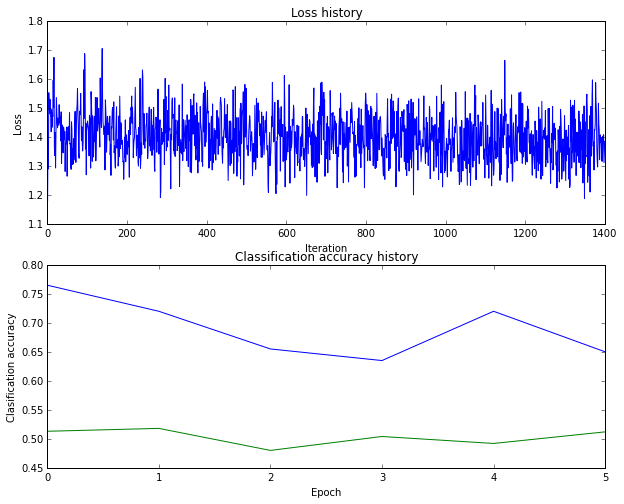

iterations:  1500
iteration 0 / 1500: loss 1.264921
iteration 100 / 1500: loss 1.368722
iteration 200 / 1500: loss 1.497776
iteration 300 / 1500: loss 1.431218
iteration 400 / 1500: loss 1.437661
iteration 500 / 1500: loss 1.479769
iteration 600 / 1500: loss 1.346656
iteration 700 / 1500: loss 1.343805
iteration 800 / 1500: loss 1.326756
iteration 900 / 1500: loss 1.401698
iteration 1000 / 1500: loss 1.233251
iteration 1100 / 1500: loss 1.393795
iteration 1200 / 1500: loss 1.363939
iteration 1300 / 1500: loss 1.566505
iteration 1400 / 1500: loss 1.368426
Validation accuracy:  0.506


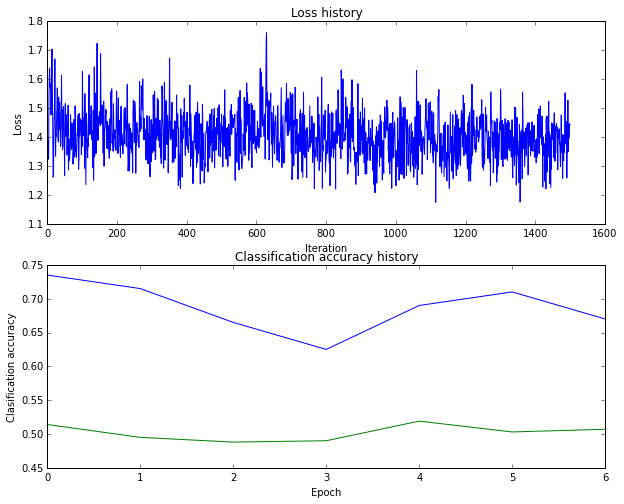

iterations:  1600
iteration 0 / 1600: loss 1.498581
iteration 100 / 1600: loss 1.484665
iteration 200 / 1600: loss 1.408315
iteration 300 / 1600: loss 1.268907
iteration 400 / 1600: loss 1.428086
iteration 500 / 1600: loss 1.389124
iteration 600 / 1600: loss 1.419752
iteration 700 / 1600: loss 1.413071
iteration 800 / 1600: loss 1.418201
iteration 900 / 1600: loss 1.283015
iteration 1000 / 1600: loss 1.423985
iteration 1100 / 1600: loss 1.294969
iteration 1200 / 1600: loss 1.309815
iteration 1300 / 1600: loss 1.321583
iteration 1400 / 1600: loss 1.377489
iteration 1500 / 1600: loss 1.357027
Validation accuracy:  0.515


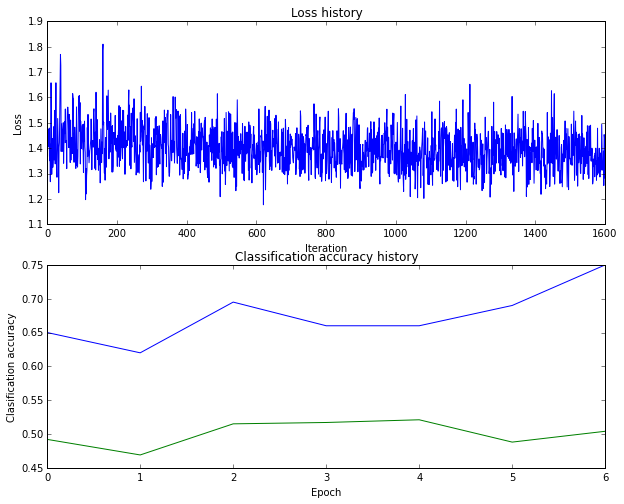

iterations:  1700
iteration 0 / 1700: loss 1.376347
iteration 100 / 1700: loss 1.741935
iteration 200 / 1700: loss 1.477288
iteration 300 / 1700: loss 1.351380
iteration 400 / 1700: loss 1.466856
iteration 500 / 1700: loss 1.358697
iteration 600 / 1700: loss 1.365634
iteration 700 / 1700: loss 1.467174
iteration 800 / 1700: loss 1.355863
iteration 900 / 1700: loss 1.382557
iteration 1000 / 1700: loss 1.357466
iteration 1100 / 1700: loss 1.213373
iteration 1200 / 1700: loss 1.418647
iteration 1300 / 1700: loss 1.356953
iteration 1400 / 1700: loss 1.389303
iteration 1500 / 1700: loss 1.474164
iteration 1600 / 1700: loss 1.394704
Validation accuracy:  0.459


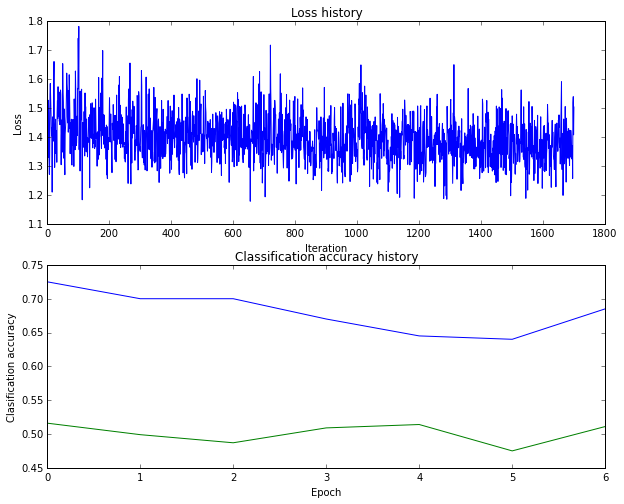

iterations:  1800
iteration 0 / 1800: loss 1.425233
iteration 100 / 1800: loss 1.209434
iteration 200 / 1800: loss 1.211881
iteration 300 / 1800: loss 1.427219
iteration 400 / 1800: loss 1.399697
iteration 500 / 1800: loss 1.399991
iteration 600 / 1800: loss 1.417749
iteration 700 / 1800: loss 1.392633
iteration 800 / 1800: loss 1.532837
iteration 900 / 1800: loss 1.359973
iteration 1000 / 1800: loss 1.403381
iteration 1100 / 1800: loss 1.416070
iteration 1200 / 1800: loss 1.376305
iteration 1300 / 1800: loss 1.389150
iteration 1400 / 1800: loss 1.262050
iteration 1500 / 1800: loss 1.256213
iteration 1600 / 1800: loss 1.351019
iteration 1700 / 1800: loss 1.330217
Validation accuracy:  0.51


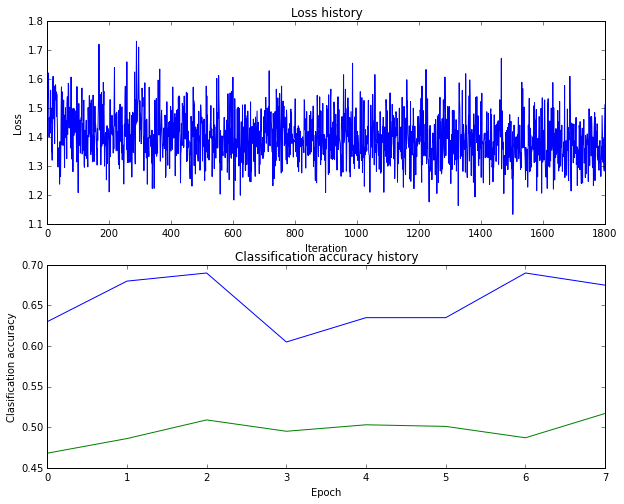

iterations:  1900
iteration 0 / 1900: loss 1.408955
iteration 100 / 1900: loss 1.464669
iteration 200 / 1900: loss 1.391985
iteration 300 / 1900: loss 1.325830
iteration 400 / 1900: loss 1.216394
iteration 500 / 1900: loss 1.498172
iteration 600 / 1900: loss 1.416229
iteration 700 / 1900: loss 1.260400
iteration 800 / 1900: loss 1.355869
iteration 900 / 1900: loss 1.404862
iteration 1000 / 1900: loss 1.234390
iteration 1100 / 1900: loss 1.368826
iteration 1200 / 1900: loss 1.321198
iteration 1300 / 1900: loss 1.372494
iteration 1400 / 1900: loss 1.497798
iteration 1500 / 1900: loss 1.362555
iteration 1600 / 1900: loss 1.247300
iteration 1700 / 1900: loss 1.375862
iteration 1800 / 1900: loss 1.211394
Validation accuracy:  0.484


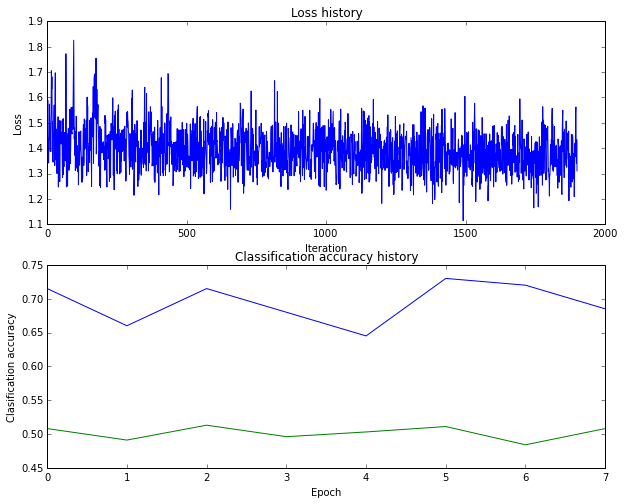

iterations:  2000
iteration 0 / 2000: loss 1.368032
iteration 100 / 2000: loss 1.448592
iteration 200 / 2000: loss 1.359559
iteration 300 / 2000: loss 1.287714
iteration 400 / 2000: loss 1.313123
iteration 500 / 2000: loss 1.373728
iteration 600 / 2000: loss 1.618164
iteration 700 / 2000: loss 1.307433
iteration 800 / 2000: loss 1.441143
iteration 900 / 2000: loss 1.284921
iteration 1000 / 2000: loss 1.341714
iteration 1100 / 2000: loss 1.290771
iteration 1200 / 2000: loss 1.597810
iteration 1300 / 2000: loss 1.335158
iteration 1400 / 2000: loss 1.340510
iteration 1500 / 2000: loss 1.366812
iteration 1600 / 2000: loss 1.357687
iteration 1700 / 2000: loss 1.407214
iteration 1800 / 2000: loss 1.506556
iteration 1900 / 2000: loss 1.376784
Validation accuracy:  0.514


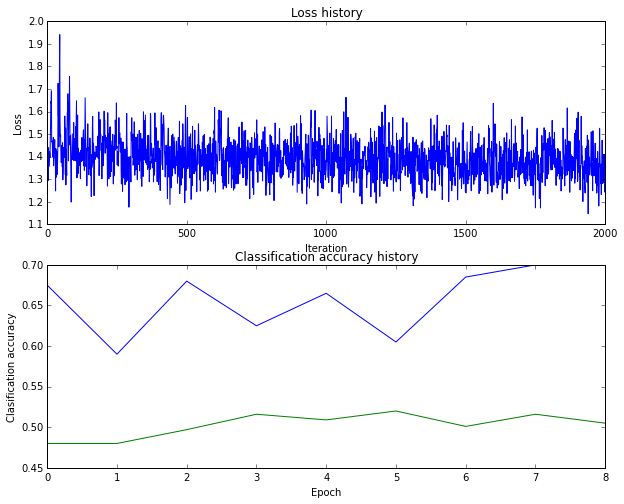

iterations:  2100
iteration 0 / 2100: loss 1.378371
iteration 100 / 2100: loss 1.453884
iteration 200 / 2100: loss 1.520955
iteration 300 / 2100: loss 1.388799
iteration 400 / 2100: loss 1.437058
iteration 500 / 2100: loss 1.348057
iteration 600 / 2100: loss 1.463397
iteration 700 / 2100: loss 1.414208
iteration 800 / 2100: loss 1.357343
iteration 900 / 2100: loss 1.489295
iteration 1000 / 2100: loss 1.301832
iteration 1100 / 2100: loss 1.384149
iteration 1200 / 2100: loss 1.303336
iteration 1300 / 2100: loss 1.424965
iteration 1400 / 2100: loss 1.347249
iteration 1500 / 2100: loss 1.320969
iteration 1600 / 2100: loss 1.455116
iteration 1700 / 2100: loss 1.460310
iteration 1800 / 2100: loss 1.461923
iteration 1900 / 2100: loss 1.306684
iteration 2000 / 2100: loss 1.412910
Validation accuracy:  0.5


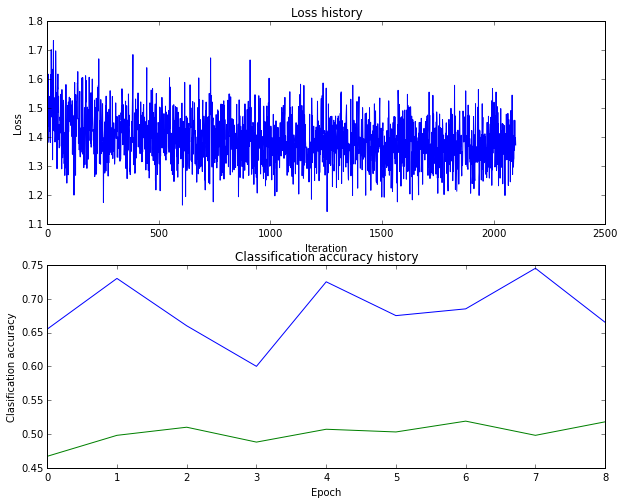

iterations:  2200
iteration 0 / 2200: loss 1.393207
iteration 100 / 2200: loss 1.417636
iteration 200 / 2200: loss 1.352555
iteration 300 / 2200: loss 1.449407
iteration 400 / 2200: loss 1.411776
iteration 500 / 2200: loss 1.374520
iteration 600 / 2200: loss 1.231407
iteration 700 / 2200: loss 1.396821
iteration 800 / 2200: loss 1.376548
iteration 900 / 2200: loss 1.324708
iteration 1000 / 2200: loss 1.424015
iteration 1100 / 2200: loss 1.429958
iteration 1200 / 2200: loss 1.473079
iteration 1300 / 2200: loss 1.252355
iteration 1400 / 2200: loss 1.381914
iteration 1500 / 2200: loss 1.320039
iteration 1600 / 2200: loss 1.292768
iteration 1700 / 2200: loss 1.304671
iteration 1800 / 2200: loss 1.222672
iteration 1900 / 2200: loss 1.261761
iteration 2000 / 2200: loss 1.275811
iteration 2100 / 2200: loss 1.335259
Validation accuracy:  0.518


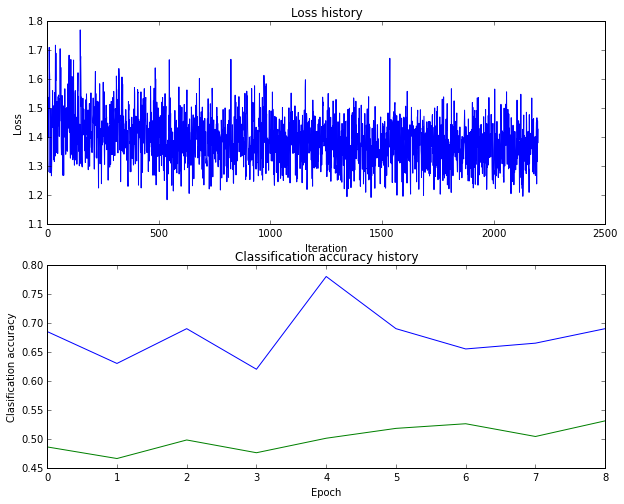

iterations:  2300
iteration 0 / 2300: loss 1.317166
iteration 100 / 2300: loss 1.334430
iteration 200 / 2300: loss 1.305659
iteration 300 / 2300: loss 1.371423
iteration 400 / 2300: loss 1.281540
iteration 500 / 2300: loss 1.485722
iteration 600 / 2300: loss 1.379165
iteration 700 / 2300: loss 1.543341
iteration 800 / 2300: loss 1.379763
iteration 900 / 2300: loss 1.328905
iteration 1000 / 2300: loss 1.469576
iteration 1100 / 2300: loss 1.450303
iteration 1200 / 2300: loss 1.405497
iteration 1300 / 2300: loss 1.230874
iteration 1400 / 2300: loss 1.371996
iteration 1500 / 2300: loss 1.450625
iteration 1600 / 2300: loss 1.227972
iteration 1700 / 2300: loss 1.340959
iteration 1800 / 2300: loss 1.347036
iteration 1900 / 2300: loss 1.344493
iteration 2000 / 2300: loss 1.334156
iteration 2100 / 2300: loss 1.299119
iteration 2200 / 2300: loss 1.493086
Validation accuracy:  0.517


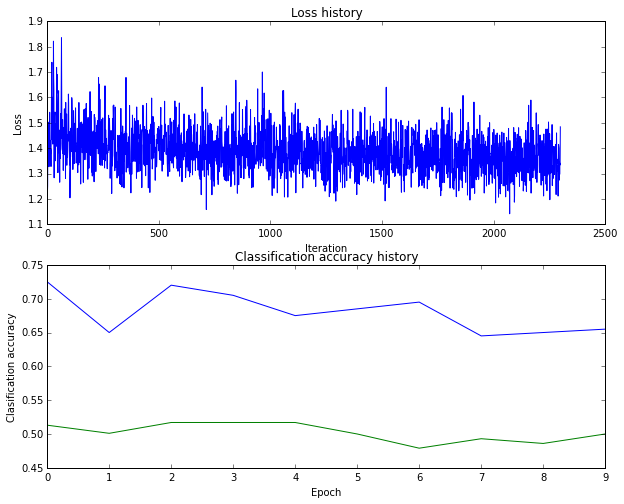

In [11]:
iterations = np.arange(1000,2400,100)
for i in iterations:
    print "iterations: ", i

    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=i, batch_size=200,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

    # Predict on the validation set
    val_acc = (net.predict(X_val) == y_val).mean()
    print 'Validation accuracy: ', val_acc
    
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()

number of neurons:  50
iteration 0 / 2000: loss 6.316629
iteration 100 / 2000: loss 2.861759
iteration 200 / 2000: loss 2.274746
iteration 300 / 2000: loss 2.083601
iteration 400 / 2000: loss 1.976605
iteration 500 / 2000: loss 1.838503
iteration 600 / 2000: loss 1.982983
iteration 700 / 2000: loss 1.766796
iteration 800 / 2000: loss 1.718622
iteration 900 / 2000: loss 1.780127
iteration 1000 / 2000: loss 1.682178
iteration 1100 / 2000: loss 1.710618
iteration 1200 / 2000: loss 1.617107
iteration 1300 / 2000: loss 1.649217
iteration 1400 / 2000: loss 1.709167
iteration 1500 / 2000: loss 1.615030
iteration 1600 / 2000: loss 1.531962
iteration 1700 / 2000: loss 1.598637
iteration 1800 / 2000: loss 1.647495
iteration 1900 / 2000: loss 1.437863
Validation accuracy:  0.497


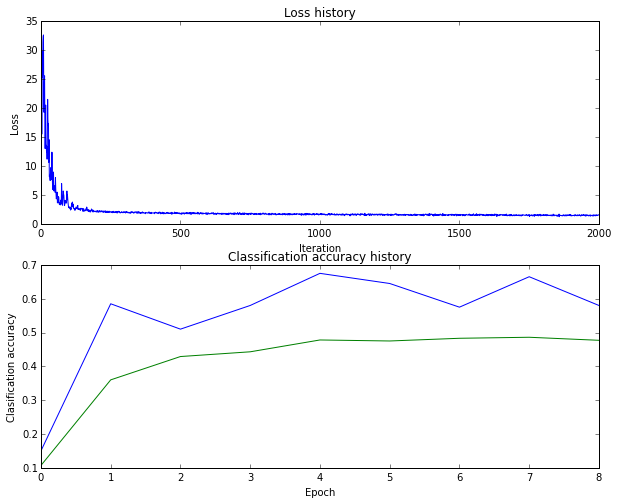

number of neurons:  100
iteration 0 / 2000: loss 5.988053
iteration 100 / 2000: loss 2.729971
iteration 200 / 2000: loss 2.172723
iteration 300 / 2000: loss 1.996569
iteration 400 / 2000: loss 1.879920
iteration 500 / 2000: loss 1.840135
iteration 600 / 2000: loss 1.795101
iteration 700 / 2000: loss 1.837360
iteration 800 / 2000: loss 1.767928
iteration 900 / 2000: loss 1.683029
iteration 1000 / 2000: loss 1.724569
iteration 1100 / 2000: loss 1.567049
iteration 1200 / 2000: loss 1.612294
iteration 1300 / 2000: loss 1.603052
iteration 1400 / 2000: loss 1.461582
iteration 1500 / 2000: loss 1.495832
iteration 1600 / 2000: loss 1.646617
iteration 1700 / 2000: loss 1.390852
iteration 1800 / 2000: loss 1.504342
iteration 1900 / 2000: loss 1.482858
Validation accuracy:  0.522


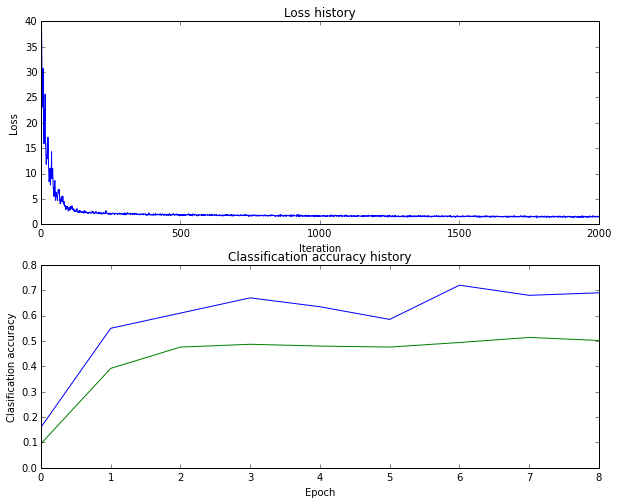

number of neurons:  150
iteration 0 / 2000: loss 5.127193
iteration 100 / 2000: loss 3.041105
iteration 200 / 2000: loss 2.081577
iteration 300 / 2000: loss 2.069409
iteration 400 / 2000: loss 1.909660
iteration 500 / 2000: loss 1.896798
iteration 600 / 2000: loss 1.806600
iteration 700 / 2000: loss 1.758600
iteration 800 / 2000: loss 1.796433
iteration 900 / 2000: loss 1.656633
iteration 1000 / 2000: loss 1.539675
iteration 1100 / 2000: loss 1.653300
iteration 1200 / 2000: loss 1.635954
iteration 1300 / 2000: loss 1.741220
iteration 1400 / 2000: loss 1.583708
iteration 1500 / 2000: loss 1.594522
iteration 1600 / 2000: loss 1.490409
iteration 1700 / 2000: loss 1.474474
iteration 1800 / 2000: loss 1.325803
iteration 1900 / 2000: loss 1.464608
Validation accuracy:  0.534


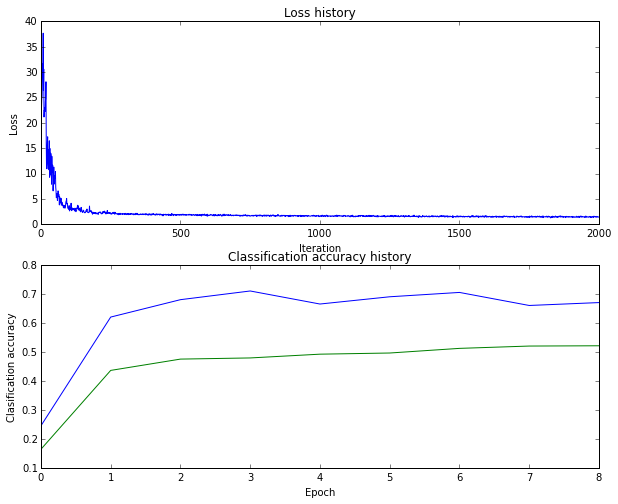

number of neurons:  200
iteration 0 / 2000: loss 4.804194
iteration 100 / 2000: loss 3.010365
iteration 200 / 2000: loss 2.236407
iteration 300 / 2000: loss 1.955854
iteration 400 / 2000: loss 2.062337
iteration 500 / 2000: loss 1.738755
iteration 600 / 2000: loss 1.820902
iteration 700 / 2000: loss 1.696823
iteration 800 / 2000: loss 1.776848
iteration 900 / 2000: loss 1.721648
iteration 1000 / 2000: loss 1.681976
iteration 1100 / 2000: loss 1.679401
iteration 1200 / 2000: loss 1.598569
iteration 1300 / 2000: loss 1.614863
iteration 1400 / 2000: loss 1.551277
iteration 1500 / 2000: loss 1.387281
iteration 1600 / 2000: loss 1.551852
iteration 1700 / 2000: loss 1.552161
iteration 1800 / 2000: loss 1.337721
iteration 1900 / 2000: loss 1.442090
Validation accuracy:  0.516


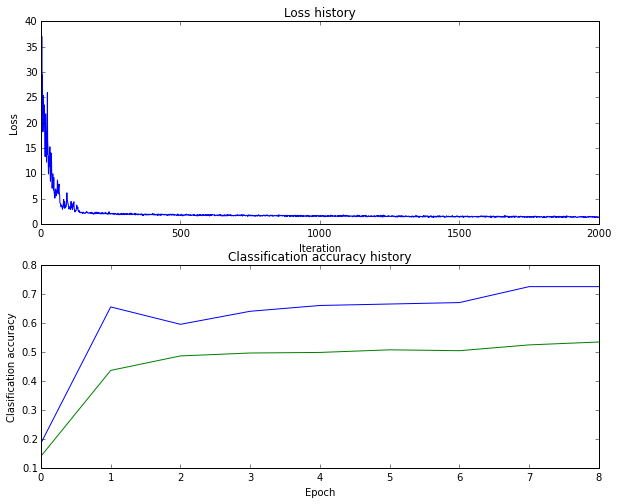

number of neurons:  250
iteration 0 / 2000: loss 5.062398
iteration 100 / 2000: loss 3.393269
iteration 200 / 2000: loss 2.343690
iteration 300 / 2000: loss 2.084114
iteration 400 / 2000: loss 1.956682
iteration 500 / 2000: loss 1.929694
iteration 600 / 2000: loss 1.712964
iteration 700 / 2000: loss 1.797919
iteration 800 / 2000: loss 1.690138
iteration 900 / 2000: loss 1.634144
iteration 1000 / 2000: loss 1.601519
iteration 1100 / 2000: loss 1.746713
iteration 1200 / 2000: loss 1.543921
iteration 1300 / 2000: loss 1.624706
iteration 1400 / 2000: loss 1.384684
iteration 1500 / 2000: loss 1.655606
iteration 1600 / 2000: loss 1.480665
iteration 1700 / 2000: loss 1.589157
iteration 1800 / 2000: loss 1.391667
iteration 1900 / 2000: loss 1.536716
Validation accuracy:  0.531


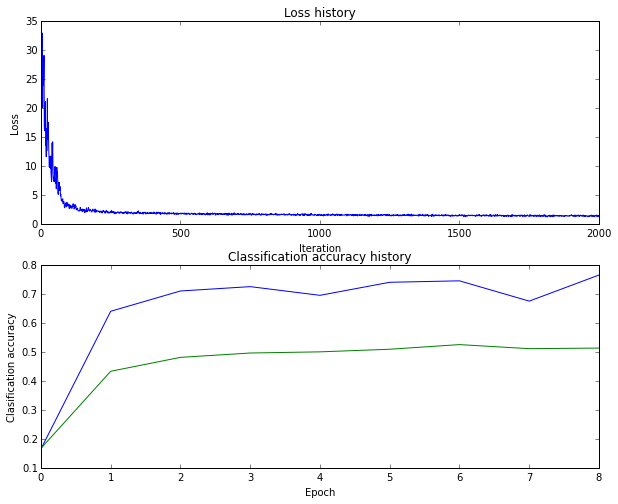

number of neurons:  300
iteration 0 / 2000: loss 4.181563
iteration 100 / 2000: loss 2.853492
iteration 200 / 2000: loss 2.389846
iteration 300 / 2000: loss 1.889828
iteration 400 / 2000: loss 1.828529
iteration 500 / 2000: loss 1.902805
iteration 600 / 2000: loss 1.931401
iteration 700 / 2000: loss 1.748028
iteration 800 / 2000: loss 1.689183
iteration 900 / 2000: loss 1.690217
iteration 1000 / 2000: loss 1.552596
iteration 1100 / 2000: loss 1.663553
iteration 1200 / 2000: loss 1.567873
iteration 1300 / 2000: loss 1.598591
iteration 1400 / 2000: loss 1.517634
iteration 1500 / 2000: loss 1.556829
iteration 1600 / 2000: loss 1.400505
iteration 1700 / 2000: loss 1.504876
iteration 1800 / 2000: loss 1.547717
iteration 1900 / 2000: loss 1.465545
Validation accuracy:  0.525


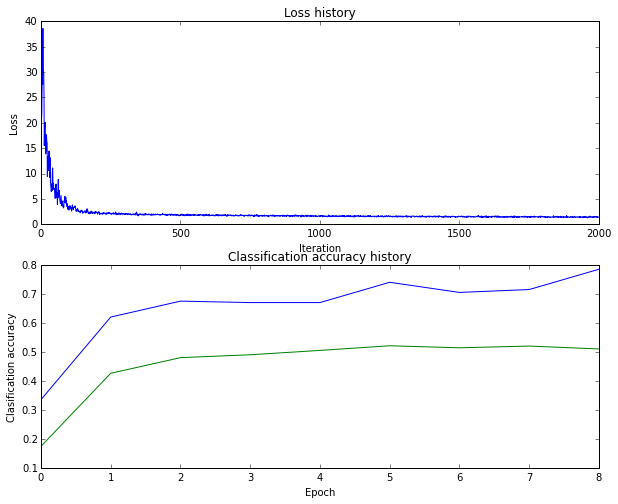

number of neurons:  350
iteration 0 / 2000: loss 3.825429
iteration 100 / 2000: loss 3.240009
iteration 200 / 2000: loss 2.274052
iteration 300 / 2000: loss 1.995302
iteration 400 / 2000: loss 1.899143
iteration 500 / 2000: loss 1.922991
iteration 600 / 2000: loss 1.790709
iteration 700 / 2000: loss 1.747231
iteration 800 / 2000: loss 1.720798
iteration 900 / 2000: loss 1.731815
iteration 1000 / 2000: loss 1.679031
iteration 1100 / 2000: loss 1.639362
iteration 1200 / 2000: loss 1.548763
iteration 1300 / 2000: loss 1.497833
iteration 1400 / 2000: loss 1.535880
iteration 1500 / 2000: loss 1.558362
iteration 1600 / 2000: loss 1.493104
iteration 1700 / 2000: loss 1.500520
iteration 1800 / 2000: loss 1.477771
iteration 1900 / 2000: loss 1.402771
Validation accuracy:  0.535


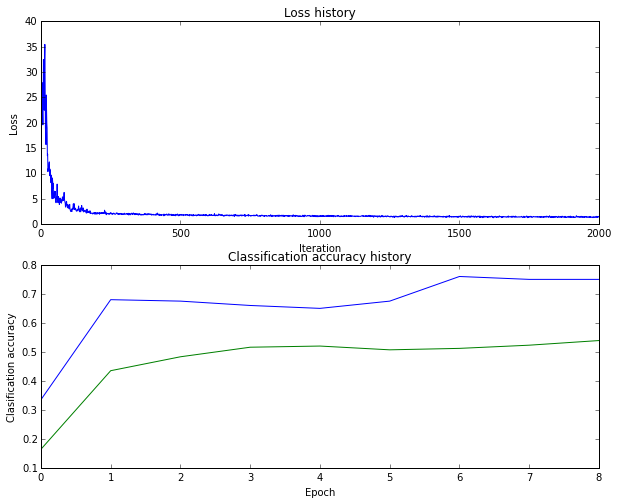

number of neurons:  400
iteration 0 / 2000: loss 3.958890
iteration 100 / 2000: loss 2.906116
iteration 200 / 2000: loss 2.332139
iteration 300 / 2000: loss 2.075310
iteration 400 / 2000: loss 1.871546
iteration 500 / 2000: loss 1.808179
iteration 600 / 2000: loss 1.645589
iteration 700 / 2000: loss 1.848042
iteration 800 / 2000: loss 1.620039
iteration 900 / 2000: loss 1.690966
iteration 1000 / 2000: loss 1.609722
iteration 1100 / 2000: loss 1.451730
iteration 1200 / 2000: loss 1.567801
iteration 1300 / 2000: loss 1.482266
iteration 1400 / 2000: loss 1.439259
iteration 1500 / 2000: loss 1.494978
iteration 1600 / 2000: loss 1.545913
iteration 1700 / 2000: loss 1.581163
iteration 1800 / 2000: loss 1.499741
iteration 1900 / 2000: loss 1.550590
Validation accuracy:  0.542


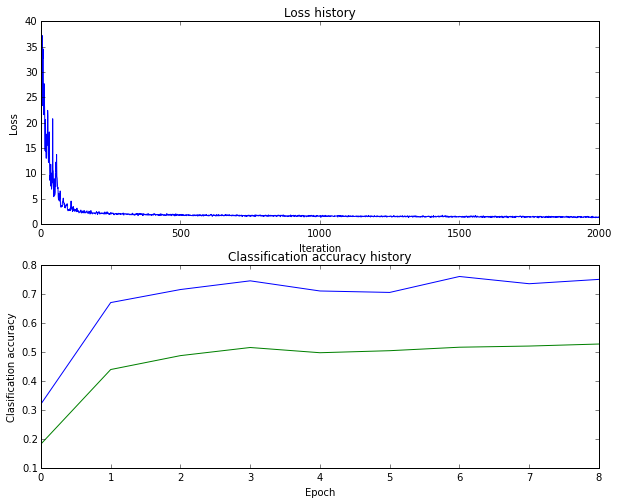

number of neurons:  450
iteration 0 / 2000: loss 4.234569
iteration 100 / 2000: loss 2.887663
iteration 200 / 2000: loss 3.366729
iteration 300 / 2000: loss 1.993547
iteration 400 / 2000: loss 1.845591
iteration 500 / 2000: loss 1.896310
iteration 600 / 2000: loss 1.729307
iteration 700 / 2000: loss 1.672870
iteration 800 / 2000: loss 1.642734
iteration 900 / 2000: loss 1.699044
iteration 1000 / 2000: loss 1.542963
iteration 1100 / 2000: loss 1.744631
iteration 1200 / 2000: loss 1.532264
iteration 1300 / 2000: loss 1.528400
iteration 1400 / 2000: loss 1.542731
iteration 1500 / 2000: loss 1.433438
iteration 1600 / 2000: loss 1.503076
iteration 1700 / 2000: loss 1.384013
iteration 1800 / 2000: loss 1.573349
iteration 1900 / 2000: loss 1.368781
Validation accuracy:  0.536


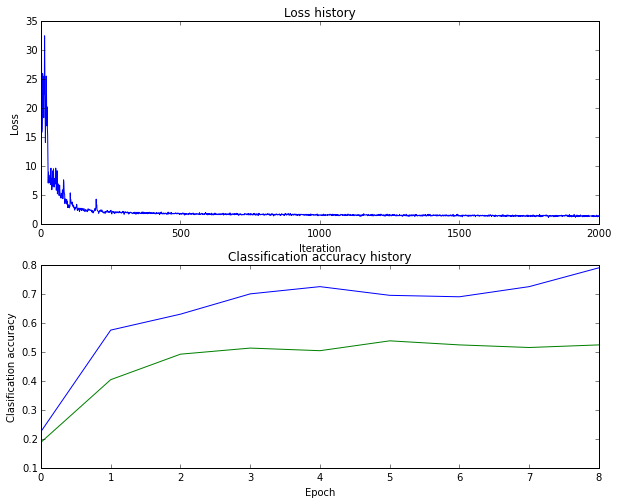

In [9]:
# for number of neurons in hidden layer!

hidden_neurons = np.arange(50, 500, 50)

for neuron in hidden_neurons:
    input_size = 32 * 32 * 3
    hidden_size = neuron
    num_classes = 10
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    
    print "number of neurons: ", hidden_size
    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

    # Predict on the validation set
    val_acc = (net.predict(X_val) == y_val).mean()
    print 'Validation accuracy: ', val_acc
    
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()
    
    

In [ ]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [17]:
input_size = 32 * 32 * 3
hidden_size = 400
num_classes = 10
lr = np.linspace(1e-3, 1e-4, 10)

for i in lr:
    best_net = TwoLayerNet(input_size, hidden_size, num_classes)
    print "Learning rate: ", i
    stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=500,
            learning_rate=i, learning_rate_decay=0.95,
            reg=0.5, verbose=True)
    
    
    val_acc = (best_net.predict(X_val) == y_val).mean()
    print 'Validation accuracy: ', val_acc

Learning rate:  0.001
iteration 0 / 1500: loss 3.855578
iteration 100 / 1500: loss 3.315223


KeyboardInterrupt: 

In [18]:
input_size = 32 * 32 * 3
hidden_size = 400
num_classes = 10

best_net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=500,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.5, verbose=True)
    
    
val_acc = (best_net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc

iteration 0 / 1500: loss 3.855578
iteration 100 / 1500: loss 3.315223
iteration 200 / 1500: loss 2.184698
iteration 300 / 1500: loss 1.894432
iteration 400 / 1500: loss 1.862844
iteration 500 / 1500: loss 1.789712
iteration 600 / 1500: loss 1.730753
iteration 700 / 1500: loss 1.692441
iteration 800 / 1500: loss 1.614695
iteration 900 / 1500: loss 1.638984
iteration 1000 / 1500: loss 1.567331
iteration 1100 / 1500: loss 1.512295
iteration 1200 / 1500: loss 1.508419
iteration 1300 / 1500: loss 1.479564
iteration 1400 / 1500: loss 1.415217
Validation accuracy:  0.547


In [15]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print 'Test accuracy: ', test_acc

Test accuracy:  0.539
